In [5]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import numpy as np
import random
import seaborn as sns
from statistics import mean 
from numpy import linalg as LA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import networkx as nx
from scipy.spatial.distance import squareform
import planarity
import progressbar
from collections import OrderedDict 
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import expected_returns

In [ ]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,1,1)
data_sp500 = yf.download(tickers, start=start, end=end)

In [679]:
data_spy = yf.download(['^GSPC'], start=datetime.datetime(2015,1,1), end=datetime.datetime(2021,1,1))
df_close_price_spy = data_spy.copy()["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [681]:
test_start = datetime.datetime(2020,1,1)
%store -r data_sp500
%store -r tickers
%store -r df_close_price_spy

In [21]:
df_close_price = data_sp500.copy()["Adj Close"]

In [22]:
df_close_price

A        AAL         AAP        AAPL        ABBV  \
Date                                                                    
2014-12-31         NaN        NaN         NaN         NaN         NaN   
2015-01-02   38.341019  51.079918  155.756485   24.898552   50.408062   
2015-01-05   37.622601  51.051483  153.703476   24.197117   49.459408   
2015-01-06   37.036514  50.255585  153.595398   24.199400   49.214603   
2015-01-07   37.528069  50.227158  156.895981   24.538729   51.203693   
...                ...        ...         ...         ...         ...   
2020-12-24  117.117928  15.660000  160.679993  131.970001  103.260002   
2020-12-28  117.637077  16.059999  158.800003  136.690002  103.449997   
2020-12-29  117.038063  15.860000  156.690002  134.869995  104.699997   
2020-12-30  117.197800  16.150000  157.660004  133.720001  105.269997   
2020-12-31  118.295998  15.770000  157.509995  132.690002  107.150002   

                  ABC        ABMD         ABT         ACN        ADBE  ...  \
Date                                                                   ...   
2014-12-31        NaN         NaN         NaN         NaN         NaN  ...   
2015-01-02  81.840622   37.310001   39.861053   78.635353   72.339996  ...   
2015-01-05  81.143990   37.070000   39.869926   77.307655   71.980003  ...   
2015-01-06  81.587296   36.130001   39.417171   76.750000   70.529999  ...   
2015-01-07  83.215782   37.279999   39.736771   78.360962   71.110001  ...   
...               ...         ...         ...         ...         ...  ...   
2020-12-24  96.970001  303.410004  108.349998  256.423737  499.859985  ...   
2020-12-28  96.800003  312.910004  107.790001  258.795624  498.950012  ...   
2020-12-29  97.120003  320.929993  108.330002  256.882202  502.109985  ...   
2020-12-30  96.959999  323.920013  108.440002  256.662933  497.450012  ...   
2020-12-31  97.760002  324.200012  109.489998  260.320435  500.119995  ...   

                  XLNX        XOM       XRAY        XRX         XYL  \
Date                                                                  
2014-12-31         NaN        NaN        NaN        NaN         NaN   
2015-01-02   38.451271  70.862823  49.771557  29.196169   35.135895   
2015-01-05   37.745739  68.923904  49.426529  28.559168   32.949116   
2015-01-06   37.198963  68.557472  48.813129  28.176956   32.755360   
2015-01-07   37.216599  69.252136  50.078251  28.537933   33.013718   
...                ...        ...        ...        ...         ...   
2020-12-24  141.990005  41.599998  51.820000  22.333601  100.250000   
2020-12-28  141.520004  41.740002  52.310001  23.025963  100.370003   
2020-12-29  139.899994  41.270000  51.250000  22.660000   99.510002   
2020-12-30  142.100006  41.599998  51.459999  22.889999  100.779999   
2020-12-31  141.770004  41.220001  52.360001  23.190001  101.790001   

                   YUM         ZBH        ZBRA       ZION         ZTS  
Date                                                                   
2014-12-31         NaN         NaN         NaN        NaN         NaN  
2015-01-02   46.341526  107.238960   77.430000  25.291636   41.577934  
2015-01-05   45.399967  111.239365   76.339996  24.343983   41.328331  
2015-01-06   44.842720  110.296432   75.790001  23.414213   40.925125  
2015-01-07   46.328712  113.039528   77.720001  23.637711   41.769932  
...                ...         ...         ...        ...         ...  
2020-12-24  107.540001  149.250000  376.890015  43.340000  160.720001  
2020-12-28  109.779999  148.889999  382.589996  43.360001  162.389999  
2020-12-29  109.449997  152.449997  378.040009  42.770000  163.119995  
2020-12-30  109.510002  152.220001  383.750000  43.220001  164.270004  
2020-12-31  108.559998  154.089996  384.329987  43.439999  165.500000  

[1517 rows x 505 columns]

In [286]:
df_logreturn = df_close_price.loc[:test_start].copy()

In [287]:
for i in list(df_close_price):
    df_logreturn.loc[:,i] = np.log(df_close_price[i]) - np.log(df_close_price[i].shift(1))

In [288]:
df_logreturn = df_logreturn.dropna(how='all')

In [289]:
df_logreturn = df_logreturn.dropna(axis='columns')

In [290]:
df_logreturn

A       AAL       AAP      AAPL      ABBV       ABC  \
Date                                                                     
2015-01-05 -0.018915 -0.000557 -0.013269 -0.028576 -0.018999 -0.008548   
2015-01-06 -0.015701 -0.015713 -0.000703  0.000094 -0.004962  0.005448   
2015-01-07  0.013185 -0.000566  0.021261  0.013925  0.039621  0.019763   
2015-01-08  0.029534  0.012187  0.008727  0.037702  0.010404  0.002281   
2015-01-09 -0.007364 -0.031040 -0.005102  0.001072 -0.027736  0.008748   
...              ...       ...       ...       ...       ...       ...   
2019-12-24  0.000469 -0.004104  0.003744  0.000950 -0.004442 -0.002105   
2019-12-26  0.001757  0.016653 -0.008129  0.019646 -0.000223 -0.004341   
2019-12-27 -0.000351 -0.042340 -0.005793 -0.000380 -0.007038 -0.001648   
2019-12-30 -0.003997 -0.004935  0.004851  0.005918 -0.007652 -0.015070   
2019-12-31  0.004818  0.013338  0.006515  0.007280  0.000226  0.016365   

                ABMD       ABT       ACN      ADBE  ...      XLNX       XOM  \
Date                                                ...                       
2015-01-05 -0.006453  0.000223 -0.017028 -0.004989  ... -0.018519 -0.027743   
2015-01-06 -0.025684 -0.011421 -0.007240 -0.020350  ... -0.014592 -0.005331   
2015-01-07  0.031333  0.008075  0.020772  0.008190  ...  0.000474  0.010082   
2015-01-08  0.044078  0.020346  0.015134  0.025135  ...  0.022030  0.016507   
2015-01-09 -0.014218 -0.010563 -0.001113 -0.014922  ... -0.000928 -0.001410   
...              ...       ...       ...       ...  ...       ...       ...   
2019-12-24  0.010854 -0.000802  0.003693  0.002095  ... -0.004154 -0.003849   
2019-12-26 -0.007515  0.000000  0.002077  0.004721  ...  0.001927  0.001570   
2019-12-27 -0.010227  0.001374  0.000801 -0.001239  ... -0.002638 -0.003428   
2019-12-30 -0.011766 -0.006889 -0.007473 -0.007434  ... -0.007547 -0.005884   
2019-12-31  0.019534  0.000691 -0.000332  0.004467  ...  0.000921  0.004308   

                XRAY       XRX       XYL       YUM       ZBH      ZBRA  \
Date                                                                     
2015-01-05 -0.006956 -0.022059 -0.064259 -0.020527  0.036625 -0.014177   
2015-01-06 -0.012488 -0.013474 -0.005898 -0.012350 -0.008513 -0.007231   
2015-01-07  0.025587  0.012730  0.007857  0.032601  0.024566  0.025146   
2015-01-08  0.024389  0.027157  0.007518  0.017270  0.010561  0.021134   
2015-01-09 -0.014676 -0.005809 -0.019043 -0.001768 -0.014529  0.014508   
...              ...       ...       ...       ...       ...       ...   
2019-12-24  0.000524  0.000535 -0.003934  0.005196 -0.002450 -0.009392   
2019-12-26 -0.010208  0.002939 -0.000509  0.014447 -0.002193  0.000354   
2019-12-27  0.005469 -0.004546  0.003049  0.001080 -0.001931  0.006191   
2019-12-30 -0.007771 -0.004327 -0.001269 -0.012442 -0.008435 -0.007410   
2019-12-31  0.003363 -0.000813  0.000635  0.000894  0.006233  0.005220   

                ZION       ZTS  
Date                            
2015-01-05 -0.038189 -0.006021  
2015-01-06 -0.038941 -0.009804  
2015-01-07  0.009500  0.020433  
2015-01-08  0.013897  0.015281  
2015-01-09 -0.028373  0.001583  
...              ...       ...  
2019-12-24  0.003694  0.004146  
2019-12-26  0.002520  0.000827  
2019-12-27 -0.003102  0.001653  
2019-12-30  0.005229 -0.007835  
2019-12-31  0.002893  0.001058  

[1252 rows x 484 columns]

In [291]:
logreturn = df_logreturn.to_numpy()

In [292]:
logreturn.shape

(1252, 484)

In [293]:
T = logreturn.shape[0]

In [294]:
N = logreturn.shape[1]

In [295]:
saved_mean = logreturn.mean(axis=0)
saved_std = logreturn.std(axis=0)

In [296]:
normed_logreturn = (logreturn - logreturn.mean(axis=0)) / logreturn.std(axis=0)

In [167]:
R = np.transpose(normed_logreturn)

In [168]:
R.shape

(484, 1252)

In [32]:
c = 1/T*R.dot(R.transpose())

In [33]:
for i in range(N):
    c[i][i] = 1

In [6]:
%store -r c 

In [7]:
c.shape

(484, 484)

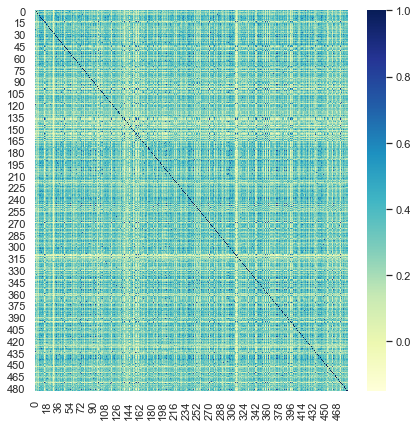

In [8]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(c,cmap="YlGnBu")

In [9]:
w, v = LA.eig(c)

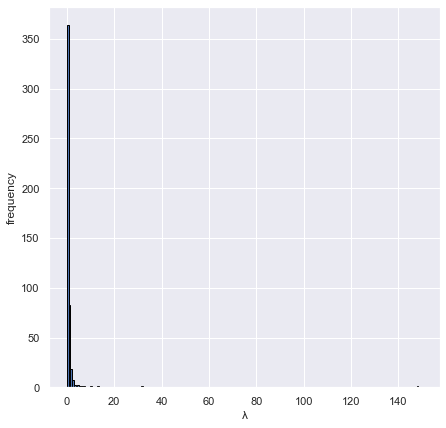

In [10]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(w,bins = 200, range = (0,150), edgecolor='black', linewidth=1)
plt.ylabel('frequency')
plt.xlabel('λ');

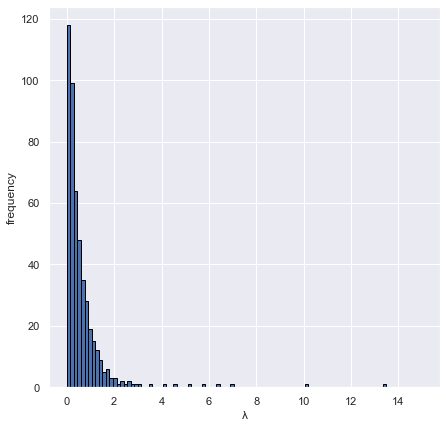

In [11]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(w,bins = 100, range = (0,15), edgecolor='black', linewidth=1)
plt.ylabel('frequency')
plt.xlabel('λ');

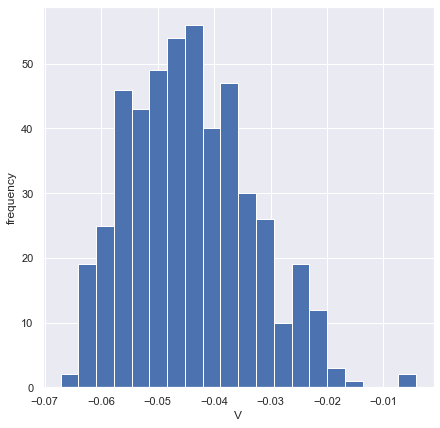

In [12]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(v.transpose()[0],bins = 20)
plt.ylabel('frequency')
plt.xlabel('V');

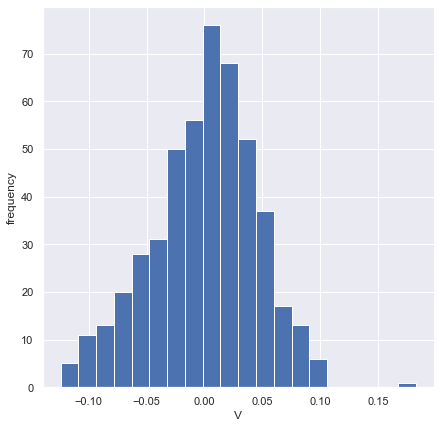

In [13]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(v.transpose()[483],bins = 20)
plt.ylabel('frequency') 
plt.xlabel('V');

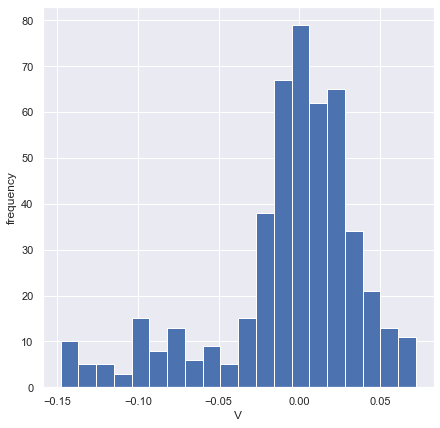

In [14]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(v.transpose()[1],bins = 20)
plt.ylabel('frequency')
plt.xlabel('V');

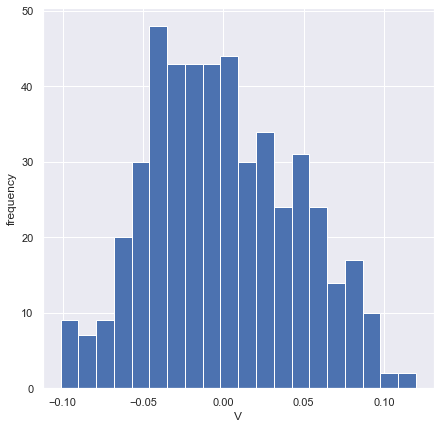

In [15]:
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(v.transpose()[2],bins = 20)
plt.ylabel('frequency')
plt.xlabel('V');

In [57]:
q = N/T
lambda_pos = (1+np.sqrt(q))**2
lambda_neg = (1-np.sqrt(q))**2

In [75]:
lambda_pos

2.6300949913258496

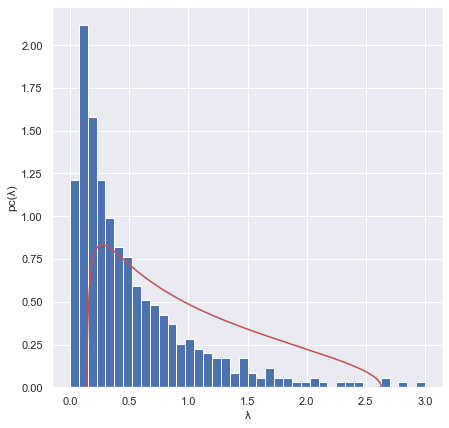

In [63]:
x_coords = np.linspace(lambda_neg,lambda_pos,1000)
y_coords = 1/(2*np.pi*q)*np.sqrt((x_coords-lambda_neg)*(lambda_pos-x_coords))/x_coords
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(w, density=True,bins = 40, range = (0,3))
plt.plot(x_coords,y_coords, 'r')
plt.ylabel('pc(λ)')
plt.xlabel('λ');

In [66]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [71]:
R.shape

(484, 1252)

In [69]:
shuffle_along_axis(np.arange(4).reshape((2,2)), axis=1)

array([[1, 0],
       [3, 2]])

In [38]:
R_random = shuffle_along_axis(R, axis=1)

In [39]:
c_random = 1/T*R_random.dot(R_random.transpose())

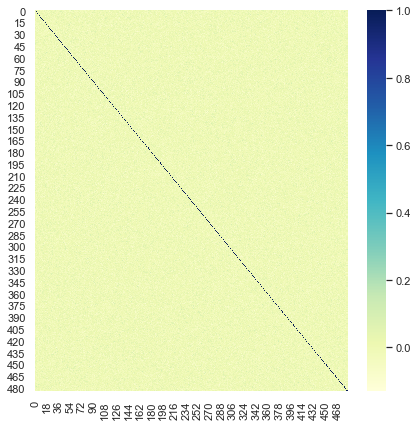

In [40]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(c_random,cmap="YlGnBu")

In [41]:
w_random, v_random = LA.eig(c_random)

In [73]:
q

0.3865814696485623

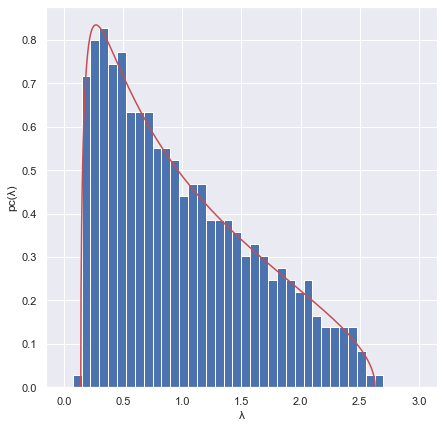

In [74]:
x_coords = np.linspace(lambda_neg,lambda_pos,1000)
y_coords = 1/(2*np.pi*q)*np.sqrt((x_coords-lambda_neg)*(lambda_pos-x_coords))/x_coords
sns.set(rc={'figure.figsize':(7,7)})
plt.hist(w_random, density=True,bins = 40, range = (0,3))
plt.plot(x_coords,y_coords, 'r')
plt.ylabel('pc(λ)')
plt.xlabel('λ');

In [43]:
stocks = list(df_logreturn.columns)
df_close_price = df_close_price[stocks]

In [44]:
# sectors = []
# for i in range(0,N):
#     stock = yf.Ticker(stocks[i])
#     sectors.append(stock.info['sector'])

In [45]:
%store -r sectors

In [53]:
second_pc_top25 = np.argsort(v.transpose()[1])[-25:]
second_pc_bottom25 = np.argsort(v.transpose()[1])[:25]
second_pc_top_sectors = []
for i in second_pc_top25:
    second_pc_top_sectors.append(sectors[i])
second_pc_bottom_sectors = []
for i in second_pc_bottom25:
    second_pc_bottom_sectors.append(sectors[i])    
Counter(second_pc_top_sectors)

Counter({'Financial Services': 25})

In [55]:
Counter(second_pc_bottom_sectors)

Counter({'Utilities': 21, 'Real Estate': 4})

In [27]:
third_pc_top25 = np.argsort(v.transpose()[2])[-25:]
third_pc_bottom25 = np.argsort(v.transpose()[2])[:25]

In [28]:
third_pc_top_sectors = []
for i in third_pc_top25:
    third_pc_top_sectors.append(sectors[i])
third_pc_bottom_sectors = []
for i in third_pc_bottom25:
    third_pc_bottom_sectors.append(sectors[i])

In [29]:
Counter(third_pc_top_sectors)

Counter({'Healthcare': 7,
         'Technology': 8,
         'Communication Services': 6,
         'Financial Services': 2,
         'Consumer Cyclical': 1,
         'Industrials': 1})

In [30]:
Counter(third_pc_bottom_sectors)

Counter({'Energy': 20,
         'Industrials': 2,
         'Utilities': 1,
         'Basic Materials': 1,
         'Financial Services': 1})

In [470]:
Counter(sectors)

Counter({'Healthcare': 64,
         'Industrials': 69,
         'Consumer Cyclical': 61,
         'Technology': 67,
         'Consumer Defensive': 32,
         'Utilities': 28,
         'Financial Services': 67,
         'Basic Materials': 19,
         'Real Estate': 30,
         'Energy': 25,
         'Communication Services': 22})

# Network Analysis

In [872]:
c.shape

(484, 484)

In [873]:
c_abs = np.absolute(c)

In [874]:
def my_vectorized_func(m):
    return 1-m
c_abs_inverse = my_vectorized_func(c_abs)

In [875]:
G0 = nx.from_numpy_matrix(c_abs_inverse)

In [876]:
dct = {'Real Estate':'tab:blue', 'Industrials':'tab:orange','Technology':'tab:green','Utilities':'tab:red',
       'Financial Services':'tab:purple','Healthcare':'tab:brown','Consumer Defensive':'tab:pink',
       'Communication Services':'tab:gray','Consumer Cyclical':'tab:olive','Energy':'tab:cyan','Basic Materials':'yellow'}

In [877]:
sectors_colour = list(map(dct.get, sectors))

In [878]:
len(sectors_colour)

484

In [879]:
print(nx.info(G0))

Name: 
Type: Graph
Number of nodes: 484
Number of edges: 117306
Average degree: 484.7355


In [880]:
mapping = dict(zip(G0, list(df_logreturn.columns)))
G0 = nx.relabel_nodes(G0, mapping)

In [881]:
mst = nx.minimum_spanning_tree(G0)

In [887]:
ticker_sector_dct = dict(zip(list(df_logreturn.columns), sectors))
MST_sector = []
for node in PMFG:
    MST_sector.append(ticker_sector_dct.get(node))
MST_colour_map = list(map(dct.get, PMFG_sector))

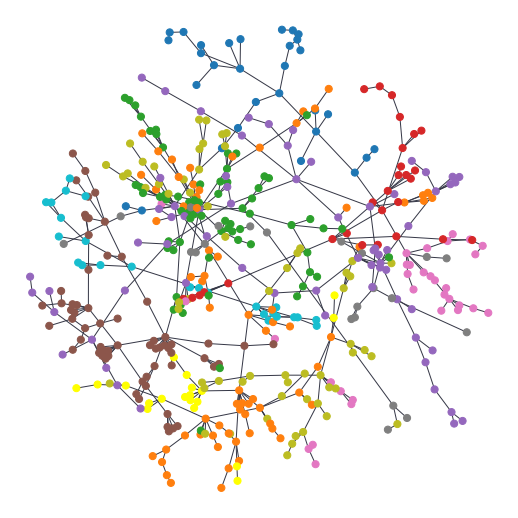

In [931]:
sns.set(rc={'figure.figsize': (7, 7)})
nx.draw(mst, node_size=50, node_color=sectors_colour,
        edge_color='#363847',  pos=nx.spring_layout(mst))

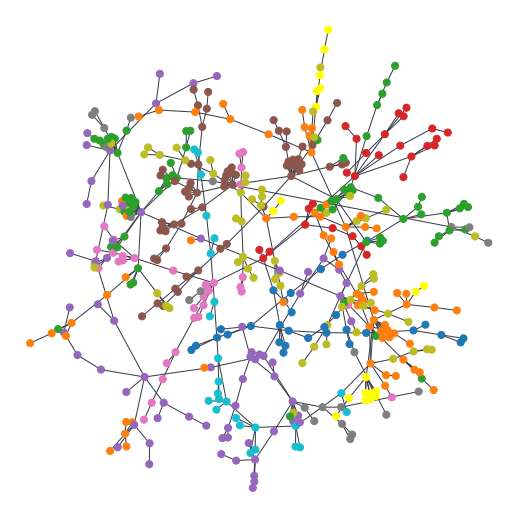

In [933]:
sns.set(rc={'figure.figsize': (7, 7)})
nx.draw(mst, node_size=50, node_color=sectors_colour,
        edge_color='#363847',  pos=nx.fruchterman_reingold_layout(mst))

In [49]:
def sort_graph_edges(G):
    sorted_edges = []
    for source, dest, data in sorted(G.edges(data=True),
                                     key=lambda x: x[2]['weight']):
        sorted_edges.append({'source': source,
                             'dest': dest,
                             'weight': data})
    return sorted_edges

In [50]:
def compute_PMFG(sorted_edges, nb_nodes):
    PMFG = nx.Graph()
    i = 0
    with progressbar.ProgressBar(max_value=len(sorted_edges)) as bar:
        for edge in sorted_edges:
            i+=1
            bar.update(i)
            PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'].get("weight"))
            if not planarity.is_planar(PMFG):
                PMFG.remove_edge(edge['source'], edge['dest'])

            if len(PMFG.edges()) == 3*(nb_nodes-2):
                break
    
    return PMFG

In [51]:
sorted_edges = sort_graph_edges(G0)

In [52]:
PMFG = compute_PMFG(sorted_edges, len(G0.nodes))

100% (116886 of 116886) |################| Elapsed Time: 0:01:31 Time:  0:01:31


In [855]:
%store -r PMFG

In [856]:
print(nx.info(PMFG))

Name: 
Type: Graph
Number of nodes: 484
Number of edges: 1446
Average degree:   5.9752


In [857]:
ticker_sector_dct = dict(zip(list(df_logreturn.columns), sectors))

In [862]:
PMFG_sector = []
for node in PMFG:
    PMFG_sector.append(ticker_sector_dct.get(node))
PMFG_colour_map = list(map(dct.get, PMFG_sector))

In [863]:
dct = {'Real Estate':'tab:blue', 'Industrials':'tab:orange','Technology':'tab:green','Utilities':'tab:red',
       'Financial Services':'tab:purple','Healthcare':'tab:brown','Consumer Defensive':'tab:pink',
       'Communication Services':'tab:gray','Consumer Cyclical':'tab:olive','Energy':'tab:cyan','Basic Materials':'yellow'}

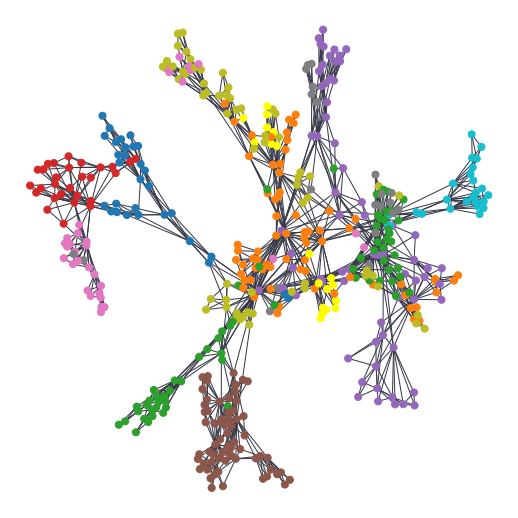

In [903]:
sns.set(rc={'figure.figsize': (7, 7)})
nx.draw(PMFG, node_size=50,
        edge_color='#363847', node_color=PMFG_colour_map,  pos=nx.spring_layout(PMFG))

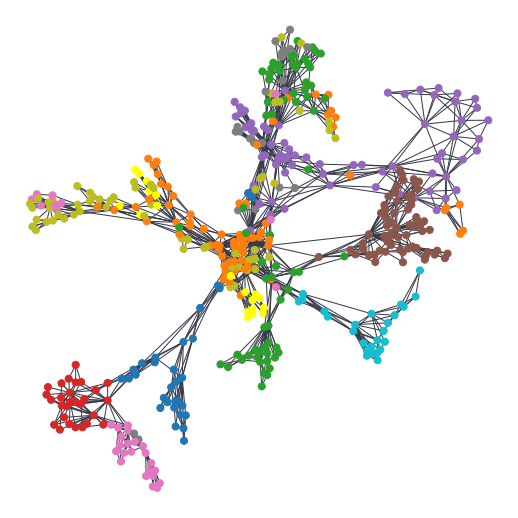

In [904]:
sns.set(rc={'figure.figsize': (7, 7)})
nx.draw(PMFG, node_size=50, node_color=PMFG_colour_map,
        edge_color='#363847',  pos=nx.fruchterman_reingold_layout(PMFG))                                                                  

# Portfolio Analysis

In [683]:
df_close_price_spy = df_close_price_spy.to_frame()

In [64]:
def Markowitz_weight(degree_list, df_close_price, df_close_price_benchmark, number_list, risk_free_rate, short):
    
    weights = []
    for number in number_list:
        portfolio_stocks = degree_list[:number]
        S = risk_models.CovarianceShrinkage(df_close_price[:test_start][portfolio_stocks]).ledoit_wolf()
        mu = expected_returns.capm_return(df_close_price[:test_start][portfolio_stocks],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
        if short == False:
            ef = EfficientFrontier(mu, S)
        else:
            ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.max_sharpe()
        weights.append(ef.clean_weights())
    
    
    S = risk_models.CovarianceShrinkage(df_close_price[:test_start][degree_list]).ledoit_wolf()
    mu = expected_returns.capm_return(df_close_price[:test_start][degree_list],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    if short == False:
        ef = EfficientFrontier(mu, S)
    else:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    ef.max_sharpe()
    all_stock_weight = ef.clean_weights()
    
    
    
    df_close_price = df_close_price.copy()[test_start:]
    df_close_price_benchmark = df_close_price_benchmark.copy()[test_start:]
    portfolio_returns = []
    all_stock_return = []
    benchmark_return = []
    portfolio_information_ratios = []
    all_stock_information_ratio = []
    portfolio_sharpe_ratios = []
    all_stock_sharpe_ratio = []
    benchmark_sharpe_ratio = []
    days = []
    for i in range(len(df_close_price)):
        portfolio_return = []
        for j in range(len(number_list)):
            stock_return = []
            portfolio_stocks = degree_list[:number_list[j]]
            for stock in portfolio_stocks:
                stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0]*weights[j].get(stock))
            portfolio_return.append(sum(stock_return))
        portfolio_returns.append(portfolio_return)
        
        stock_return = []
        for stock in degree_list:
            stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0]*all_stock_weight.get(stock))
        all_stock_return.append(sum(stock_return))
        
        benchmark_return.append((df_close_price_benchmark.iloc[i][0]-df_close_price_benchmark.iloc[0][0])/df_close_price_benchmark.iloc[0][0])
        days.append(i)
    
    portfolio_returns = list(map(list, zip(*portfolio_returns)))  
    
    for i in range(len(number_list)):
        portfolio_information_ratio = []
        portfolio_sharpe_ratio = []
        for j in range(len(df_close_price)):
            portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
            portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
        portfolio_information_ratios.append(portfolio_information_ratio)
        portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
        
    for j in range(len(df_close_price)):
        all_stock_information_ratio.append((all_stock_return[j]-benchmark_return[j])/np.std([x - y for x, y in zip(all_stock_return[:j], benchmark_return[:j])]))
        all_stock_sharpe_ratio.append((all_stock_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(all_stock_return[:j]))
        benchmark_sharpe_ratio.append((benchmark_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(benchmark_return[:j]))
         
    
    if short == False:
        for i in range(len(number_list)):
            plt.plot(days, portfolio_returns[i], label = "Portfolio Markowitz Weight Return - " + str(number_list[i]) + " Stocks (No Short Selling)")
        plt.plot(days, all_stock_return, label = "All Stock Markowitz Weight Return (No Short Selling)")
        plt.plot(days, benchmark_return, label = "SPY Return")
        plt.title("Return vs Days")
        plt.ylabel("Return")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()
        
        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Markowitz Weight Sharpe Ratio - " + str(number_list[i]) + " stocks (No Short Selling)")
        plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Markowitz Weight Sharpe Ratio (No Short Selling)")
        plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
        plt.title("Sharpe Ratio vs Days")
        plt.ylabel("Sharpe Ratio")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Markowitz Weight Information Ratio - " + str(number_list[i]) + " stocks (No Short Selling)")
        plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Markowitz Weight Information Ratio (No Short Selling)")
        plt.title("Information Ratio vs Days")
        plt.ylabel("Information Ratio")
        plt.ylabel("Days")    
        plt.legend()
        plt.show()
    
        
    else:
        for i in range(len(number_list)):
            plt.plot(days, portfolio_returns[i], label = "Portfolio Markowitz Weight Return - " + str(number_list[i]) + " Stocks (With Short Selling)")
        plt.plot(days, all_stock_return, label = "All Stock Markowitz Weight Return (With Short Selling)")
        plt.plot(days, benchmark_return, label = "SPY Return")
        plt.title("Return vs Days")
        plt.ylabel("Return")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Markowitz Weight Sharpe Ratio - " + str(number_list[i]) + " stocks (With Short Selling)")
        plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Markowitz Weight Sharpe Ratio (With Short Selling)")
        plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
        plt.title("Sharpe Ratio vs Days")
        plt.ylabel("Sharpe Ratio")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Markowitz Weight Information Ratio - " + str(number_list[i]) + " stocks (With Short Selling)")
        plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Markowitz Weight Information Ratio (With Short Selling)")
        plt.title("Information Ratio vs Days")
        plt.ylabel("Information Ratio")
        plt.xlabel("Days")    
        plt.legend()
        plt.show()

In [125]:
def uniform_weight(degree_list, df_close_price, df_close_price_benchmark, number_list, risk_free_rate):
    df_close_price = df_close_price.copy()[test_start:]
    df_close_price_benchmark = df_close_price_benchmark.copy()[test_start:]
    portfolio_returns = []
    all_stock_return = []
    benchmark_return = []
    portfolio_information_ratios = []
    all_stock_information_ratio = []
    portfolio_sharpe_ratios = []
    all_stock_sharpe_ratio = []
    benchmark_sharpe_ratio = []
    days = []
    
    for i in range(len(df_close_price)):
        portfolio_return = []
        for number in number_list:
            stock_return = []
            portfolio_stocks = degree_list[:number]
            for stock in portfolio_stocks:
                stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0])
            portfolio_return.append(mean(stock_return))
        portfolio_returns.append(portfolio_return)
        
        stock_return = []
        for stock in degree_list:
            stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0])
        all_stock_return.append(mean(stock_return))
        
        benchmark_return.append((df_close_price_benchmark.iloc[i][0]-df_close_price_benchmark.iloc[0][0])/df_close_price_benchmark.iloc[0][0])
        days.append(i)
        
    portfolio_returns = list(map(list, zip(*portfolio_returns)))
    
    for i in range(len(number_list)):
        portfolio_information_ratio = []
        portfolio_sharpe_ratio = []
        for j in range(len(df_close_price)):
            portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
            portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
        portfolio_information_ratios.append(portfolio_information_ratio)
        portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
        
    for j in range(len(df_close_price)):
        all_stock_information_ratio.append((all_stock_return[j]-benchmark_return[j])/np.std([x - y for x, y in zip(all_stock_return[:j], benchmark_return[:j])]))
        all_stock_sharpe_ratio.append((all_stock_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(all_stock_return[:j]))
        benchmark_sharpe_ratio.append((benchmark_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(benchmark_return[:j]))

    for i in range(len(number_list)):
        plt.plot(days, portfolio_returns[i], label = "Portfolio Uniform Weight Return - " + str(number_list[i]) + " stocks")
    plt.plot(days, all_stock_return, label = "All Stock Uniform Weight Return")
    plt.plot(days, benchmark_return, label = "SPY Return")
    plt.title("Return vs Days")
    plt.ylabel("Return")
    plt.xlabel("Days")
    plt.legend()
    plt.show()

    for i in range(len(number_list)):
        plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Uniform Weight Sharpe Ratio - " + str(number_list[i]) + " stocks")
    plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Uniform Weight Sharpe Ratio")
    plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
    plt.title("Sharpe Ratio vs Days")
    plt.ylabel("Sharpe Ratio")
    plt.xlabel("Days")
    plt.legend()
    plt.show()
    
    for i in range(len(number_list)):
        plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Uniform Weight Information Ratio - " + str(number_list[i]) + " stocks")
    plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Uniform Weight Information Ratio")
    plt.title("Information Ratio vs Days")
    plt.ylabel("Information Ratio")
    plt.xlabel("Days")    
    plt.legend()
    plt.show()

In [251]:
def uniform_weight_band(degree_list,degree_selected_list,df_close_price, df_close_price_benchmark, number_list, risk_free_rate, simulations):

    df_close_price = df_close_price.copy()[test_start:]
    df_close_price_benchmark = df_close_price_benchmark.copy()[test_start:]
    days = list(range(len(df_close_price)))
    
    all_portfolio_returns = []
    all_portfolio_information_ratios = []
    all_portfolio_sharpe_ratios = []
    
    benchmark_return = []
    for i in range(len(df_close_price)):
        benchmark_return.append((df_close_price_benchmark.iloc[i][0]-df_close_price_benchmark.iloc[0][0])/df_close_price_benchmark.iloc[0][0])

    
    for _ in range(simulations):
        
        shuffled_degree_selected_list =  random.sample(degree_selected_list, len(degree_selected_list))
        portfolio_returns = []
        portfolio_information_ratios = []
        portfolio_sharpe_ratios = []

        for i in range(len(df_close_price)):
            portfolio_return = []
            for number in number_list:
                stock_return = []
                portfolio_stocks = shuffled_degree_selected_list[:number]
                for stock in portfolio_stocks:
                    stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0])
                portfolio_return.append(mean(stock_return))
            portfolio_returns.append(portfolio_return)
        
        portfolio_returns = list(map(list, zip(*portfolio_returns)))

        for i in range(len(number_list)):
            portfolio_information_ratio = []
            portfolio_sharpe_ratio = []
            for j in range(len(df_close_price)):
                portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
                portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
            portfolio_information_ratios.append(portfolio_information_ratio)
            portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
            
        all_portfolio_returns.append(portfolio_returns)
        all_portfolio_information_ratios.append(portfolio_information_ratios)
        all_portfolio_sharpe_ratios.append(portfolio_sharpe_ratios)
        
    
    max_portfolio_returns = np.array(all_portfolio_returns).max(axis =0)
    min_portfolio_returns = np.array(all_portfolio_returns).min(axis =0)
    max_portfolio_information_ratios = np.array(all_portfolio_information_ratios).max(axis =0)
    min_portfolio_information_ratios = np.array(all_portfolio_information_ratios).min(axis =0)
    max_portfolio_sharpe_ratios = np.array(all_portfolio_sharpe_ratios).max(axis =0)
    min_portfolio_sharpe_ratios = np.array(all_portfolio_sharpe_ratios).min(axis =0)
    
    
    portfolio_returns = []
    all_stock_return = []
    benchmark_return = []
    portfolio_information_ratios = []
    all_stock_information_ratio = []
    portfolio_sharpe_ratios = []
    all_stock_sharpe_ratio = []
    benchmark_sharpe_ratio = []
    
    for i in range(len(df_close_price)):
        portfolio_return = []
        for number in number_list:
            stock_return = []
            portfolio_stocks = degree_list[:number]
            for stock in portfolio_stocks:
                stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0])
            portfolio_return.append(mean(stock_return))
        portfolio_returns.append(portfolio_return)
        
        stock_return = []
        for stock in degree_list:
            stock_return.append((df_close_price[stock][i]-df_close_price[stock][0])/df_close_price[stock][0])
        all_stock_return.append(mean(stock_return))
        
        benchmark_return.append((df_close_price_benchmark.iloc[i][0]-df_close_price_benchmark.iloc[0][0])/df_close_price_benchmark.iloc[0][0])
        
    portfolio_returns = list(map(list, zip(*portfolio_returns)))
    
    for i in range(len(number_list)):
        portfolio_information_ratio = []
        portfolio_sharpe_ratio = []
        for j in range(len(df_close_price)):
            portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
            portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
        portfolio_information_ratios.append(portfolio_information_ratio)
        portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
        
    for j in range(len(df_close_price)):
        all_stock_information_ratio.append((all_stock_return[j]-benchmark_return[j])/np.std([x - y for x, y in zip(all_stock_return[:j], benchmark_return[:j])]))
        all_stock_sharpe_ratio.append((all_stock_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(all_stock_return[:j]))
        benchmark_sharpe_ratio.append((benchmark_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(benchmark_return[:j]))        
    
    
    for i in range(len(number_list)):
        plt.plot(days, portfolio_returns[i], label = "Portfolio Uniform Weight Return - " + str(number_list[i]) + " stocks")
        plt.fill_between(days, max_portfolio_returns[i], min_portfolio_returns[i],alpha=0.2)
    plt.plot(days, all_stock_return, label = "All Stock Uniform Weight Return")
    plt.plot(days, benchmark_return, label = "SPY Return")
    plt.title("Return vs Days")
    plt.ylabel("Return")
    plt.xlabel("Days")
    plt.legend()
    plt.show()

    for i in range(len(number_list)):
        plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Uniform Weight Sharpe Ratio - " + str(number_list[i]) + " stocks")
        plt.fill_between(days[5:], max_portfolio_sharpe_ratios[i][5:], min_portfolio_sharpe_ratios[i][5:],alpha=0.2)
    plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Uniform Weight Sharpe Ratio")
    plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
    plt.title("Sharpe Ratio vs Days")
    plt.ylabel("Sharpe Ratio")
    plt.xlabel("Days")
    plt.legend()
    plt.show()
    
    for i in range(len(number_list)):
        plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Uniform Weight Information Ratio - " + str(number_list[i]) + " stocks")
        plt.fill_between(days[5:], max_portfolio_information_ratios[i][5:], min_portfolio_information_ratios[i][5:],alpha=0.2)
    plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Uniform Weight Information Ratio")
    plt.title("Information Ratio vs Days")
    plt.ylabel("Information Ratio")
    plt.xlabel("Days")    
    plt.legend()
    plt.show()
    
    

In [345]:
def Markowitz_weight_band(degree_list,degree_selected_list,df_close_price, df_close_price_benchmark, number_list, risk_free_rate, simulations, short):

    df_close_price_test = df_close_price.copy()[test_start:]
    df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]
    days = list(range(len(df_close_price_test)))
    
    all_portfolio_returns = []
    all_portfolio_information_ratios = []
    all_portfolio_sharpe_ratios = []
    
    benchmark_return = []
    for i in range(len(df_close_price_test)):
        benchmark_return.append((df_close_price_benchmark_test.iloc[i][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark.iloc[0][0])

    
    for _ in range(simulations):
        shuffled_degree_selected_list =  random.sample(degree_selected_list, len(degree_selected_list))
        portfolio_returns = []
        portfolio_information_ratios = []
        portfolio_sharpe_ratios = []
        
        weights = []
        for number in number_list:
            portfolio_stocks = shuffled_degree_selected_list[:number]
            S = risk_models.CovarianceShrinkage(df_close_price[:test_start][portfolio_stocks]).ledoit_wolf()
            mu = expected_returns.capm_return(df_close_price[:test_start][portfolio_stocks],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
            if short == False:
                ef = EfficientFrontier(mu, S)
            else:
                ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
            ef.max_sharpe()
            weights.append(ef.clean_weights())

        for i in range(len(df_close_price_test)):
            portfolio_return = []
            for j in range(len(number_list)):
                stock_return = []
                portfolio_stocks = shuffled_degree_selected_list[:number_list[j]]
                for stock in portfolio_stocks:
                    stock_return.append((df_close_price_test[stock][i]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weights[j].get(stock))
                portfolio_return.append(sum(stock_return))
            portfolio_returns.append(portfolio_return)
        
        portfolio_returns = list(map(list, zip(*portfolio_returns)))

        for i in range(len(number_list)):
            portfolio_information_ratio = []
            portfolio_sharpe_ratio = []
            for j in range(len(df_close_price_test)):
                portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
                portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
            portfolio_information_ratios.append(portfolio_information_ratio)
            portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
            
        all_portfolio_returns.append(portfolio_returns)
        all_portfolio_information_ratios.append(portfolio_information_ratios)
        all_portfolio_sharpe_ratios.append(portfolio_sharpe_ratios)
        
    
    max_portfolio_returns = np.array(all_portfolio_returns).max(axis =0)
    min_portfolio_returns = np.array(all_portfolio_returns).min(axis =0)
    max_portfolio_information_ratios = np.array(all_portfolio_information_ratios).max(axis =0)
    min_portfolio_information_ratios = np.array(all_portfolio_information_ratios).min(axis =0)
    max_portfolio_sharpe_ratios = np.array(all_portfolio_sharpe_ratios).max(axis =0)
    min_portfolio_sharpe_ratios = np.array(all_portfolio_sharpe_ratios).min(axis =0)    
    
    portfolio_returns = []
    all_stock_return = []
    benchmark_return = []
    portfolio_information_ratios = []
    all_stock_information_ratio = []
    portfolio_sharpe_ratios = []
    all_stock_sharpe_ratio = []
    benchmark_sharpe_ratio = []
    
    weights = []
    for number in number_list:
        portfolio_stocks = degree_list[:number]
        S = risk_models.CovarianceShrinkage(df_close_price[:test_start][portfolio_stocks]).ledoit_wolf()
        mu = expected_returns.capm_return(df_close_price[:test_start][portfolio_stocks],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
        if short == False:
            ef = EfficientFrontier(mu, S)
        else:
            ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.max_sharpe()
        weights.append(ef.clean_weights())
    
    
    S = risk_models.CovarianceShrinkage(df_close_price[:test_start][degree_list]).ledoit_wolf()
    mu = expected_returns.capm_return(df_close_price[:test_start][degree_list],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    if short == False:
        ef = EfficientFrontier(mu, S)
    else:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    ef.max_sharpe()
    all_stock_weight = ef.clean_weights()
    
    for i in range(len(df_close_price_test)):
        portfolio_return = []
        for j in range(len(number_list)):
            stock_return = []
            portfolio_stocks = degree_list[:number_list[j]]
            for stock in portfolio_stocks:
                stock_return.append((df_close_price_test[stock][i]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weights[j].get(stock))
            portfolio_return.append(sum(stock_return))
        portfolio_returns.append(portfolio_return)
        
        stock_return = []
        for stock in degree_list:
            stock_return.append((df_close_price_test[stock][i]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*all_stock_weight.get(stock))
        all_stock_return.append(sum(stock_return))
        
        benchmark_return.append((df_close_price_benchmark_test.iloc[i][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])
        
    portfolio_returns = list(map(list, zip(*portfolio_returns)))
    
    for i in range(len(number_list)):
        portfolio_information_ratio = []
        portfolio_sharpe_ratio = []
        for j in range(len(df_close_price_test)):
            portfolio_information_ratio.append((portfolio_returns[i][j]-benchmark_return[j])/np.std([x - y for x, y in zip(portfolio_returns[i][:j], benchmark_return[:j])]))
            portfolio_sharpe_ratio.append((portfolio_returns[i][j]-(1+risk_free_rate)**(j/252)+1)/np.std(portfolio_returns[i][:j]))
        portfolio_information_ratios.append(portfolio_information_ratio)
        portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
        
    for j in range(len(df_close_price_test)):
        all_stock_information_ratio.append((all_stock_return[j]-benchmark_return[j])/np.std([x - y for x, y in zip(all_stock_return[:j], benchmark_return[:j])]))
        all_stock_sharpe_ratio.append((all_stock_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(all_stock_return[:j]))
        benchmark_sharpe_ratio.append((benchmark_return[j]-(1+risk_free_rate)**(j/252)+1)/np.std(benchmark_return[:j]))
    
    if short == False:
        for i in range(len(number_list)):
            plt.plot(days, portfolio_returns[i], label = "Portfolio Markowitz Weight Return - " + str(number_list[i]) + " Stocks (No Short Selling)")
            plt.fill_between(days, max_portfolio_returns[i], min_portfolio_returns[i],alpha=0.2)
        plt.plot(days, all_stock_return, label = "All Stock Markowitz Weight Return (No Short Selling)")
        plt.plot(days, benchmark_return, label = "SPY Return")
        plt.title("Return vs Days")
        plt.ylabel("Return")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()
        
        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Markowitz Weight Sharpe Ratio - " + str(number_list[i]) + " stocks (No Short Selling)")
            plt.fill_between(days[5:], max_portfolio_sharpe_ratios[i][5:], min_portfolio_sharpe_ratios[i][5:],alpha=0.2)
        plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Markowitz Weight Sharpe Ratio (No Short Selling)")
        plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
        plt.title("Sharpe Ratio vs Days")
        plt.ylabel("Sharpe Ratio")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Markowitz Weight Information Ratio - " + str(number_list[i]) + " stocks (No Short Selling)")
            plt.fill_between(days[5:], max_portfolio_information_ratios[i][5:], min_portfolio_information_ratios[i][5:],alpha=0.2)
        plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Markowitz Weight Information Ratio (No Short Selling)")
        plt.title("Information Ratio vs Days")
        plt.ylabel("Information Ratio")
        plt.ylabel("Days")    
        plt.legend()
        plt.show()
    
        
    else:
        for i in range(len(number_list)):
            plt.plot(days, portfolio_returns[i], label = "Portfolio Markowitz Weight Return - " + str(number_list[i]) + " Stocks (With Short Selling)")
            plt.fill_between(days, max_portfolio_returns[i], min_portfolio_returns[i],alpha=0.2)
        plt.plot(days, all_stock_return, label = "All Stock Markowitz Weight Return (With Short Selling)")
        plt.plot(days, benchmark_return, label = "SPY Return")
        plt.title("Return vs Days")
        plt.ylabel("Return")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_sharpe_ratios[i][5:], label = "Portfolio Markowitz Weight Sharpe Ratio - " + str(number_list[i]) + " stocks (With Short Selling)")
            plt.fill_between(days[5:], max_portfolio_sharpe_ratios[i][5:], min_portfolio_sharpe_ratios[i][5:],alpha=0.2)
        plt.plot(days[5:], all_stock_sharpe_ratio[5:], label = "All Stock Markowitz Weight Sharpe Ratio (With Short Selling)")
        plt.plot(days[5:], benchmark_sharpe_ratio[5:], label = "SPY Sharpe Ratio")
        plt.title("Sharpe Ratio vs Days")
        plt.ylabel("Sharpe Ratio")
        plt.xlabel("Days")        
        plt.legend()
        plt.show()

        for i in range(len(number_list)):
            plt.plot(days[5:], portfolio_information_ratios[i][5:], label = "Portfolio Markowitz Weight Information Ratio - " + str(number_list[i]) + " stocks (With Short Selling)")
            plt.fill_between(days[5:], max_portfolio_information_ratios[i][5:], min_portfolio_information_ratios[i][5:],alpha=0.2)
        plt.plot(days[5:], all_stock_information_ratio[5:], label = "All Stock Markowitz Weight Information Ratio (With Short Selling)")
        plt.title("Information Ratio vs Days")
        plt.ylabel("Information Ratio")
        plt.xlabel("Days")    
        plt.legend()
        plt.show()
    

## MST

In [937]:
MST_degree_dict = {}
for k,v in mst.degree():
    MST_degree_dict[k] = (v,dict(mst.degree(weight = 'weight')).get(k))
MST_degree_dict = OrderedDict(sorted(MST_degree_dict.items(), key=lambda t: t[1][1], reverse = True))
MST_degree_dict = OrderedDict(sorted(MST_degree_dict.items(), key=lambda t: t[1][0]))
MST_degree_list = list(MST_degree_dict)

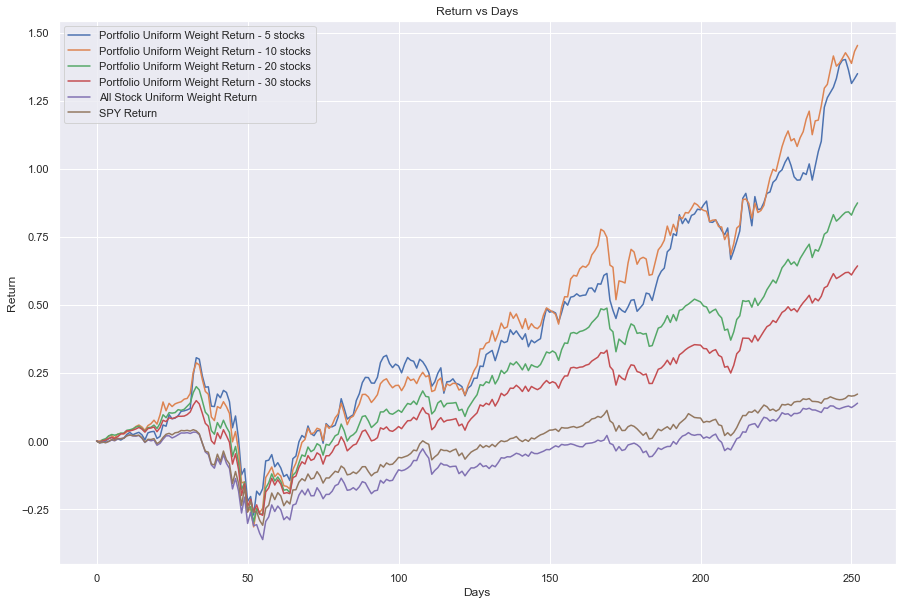

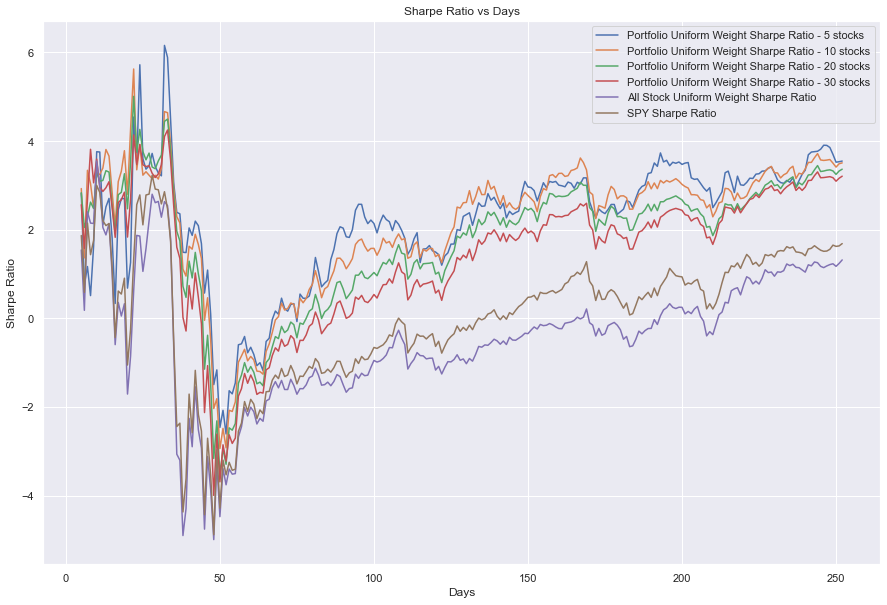

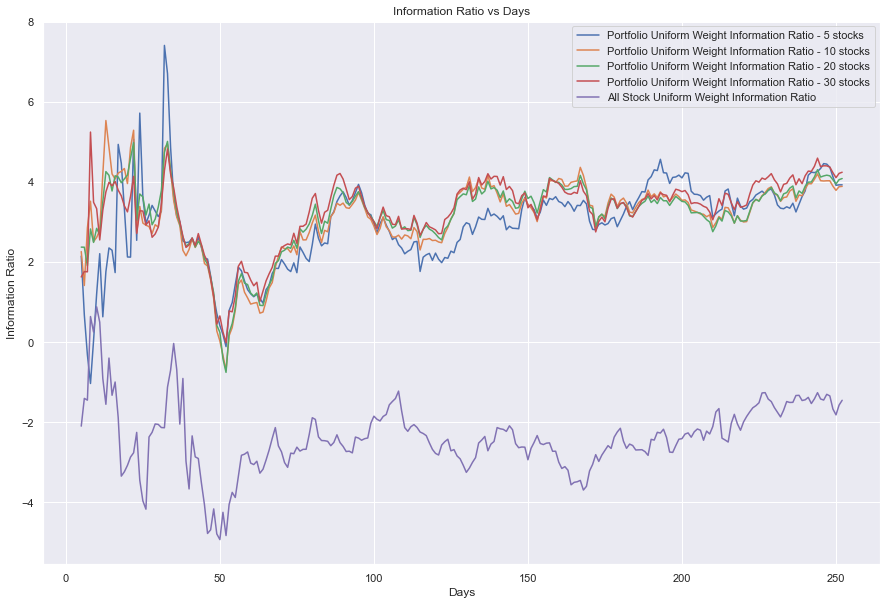

In [126]:
sns.set(rc={'figure.figsize': (15, 10)})
number_list = [5,10,20,30]
risk_free_rate = 0.001
uniform_weight(MST_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate)

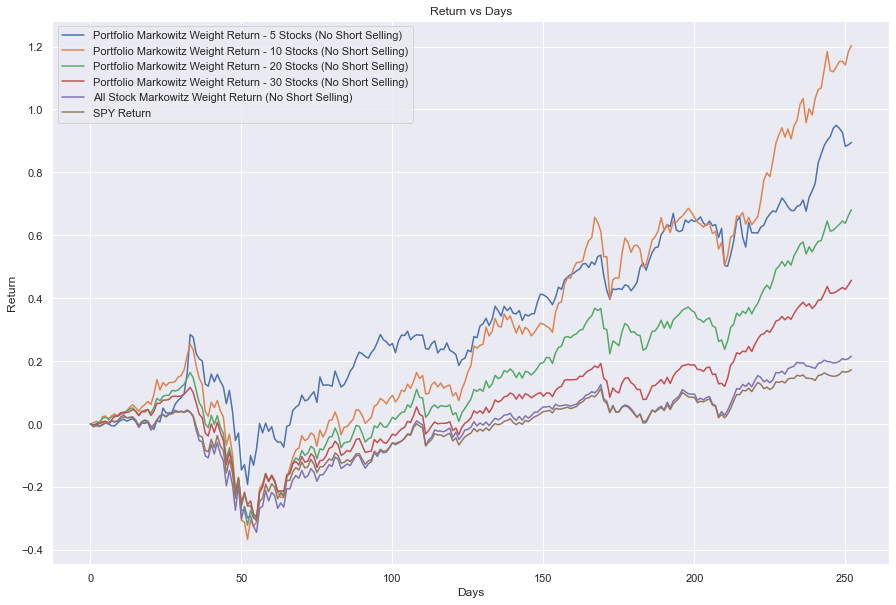

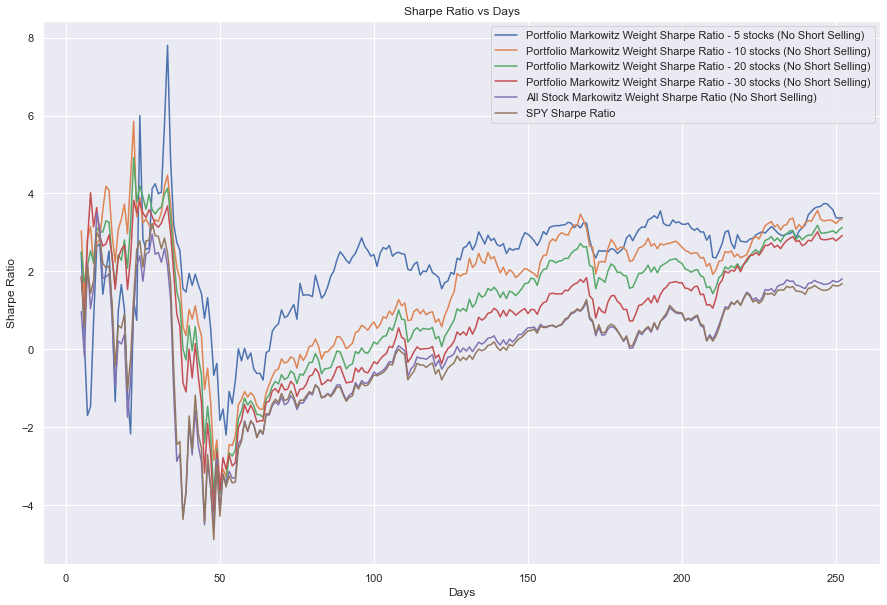

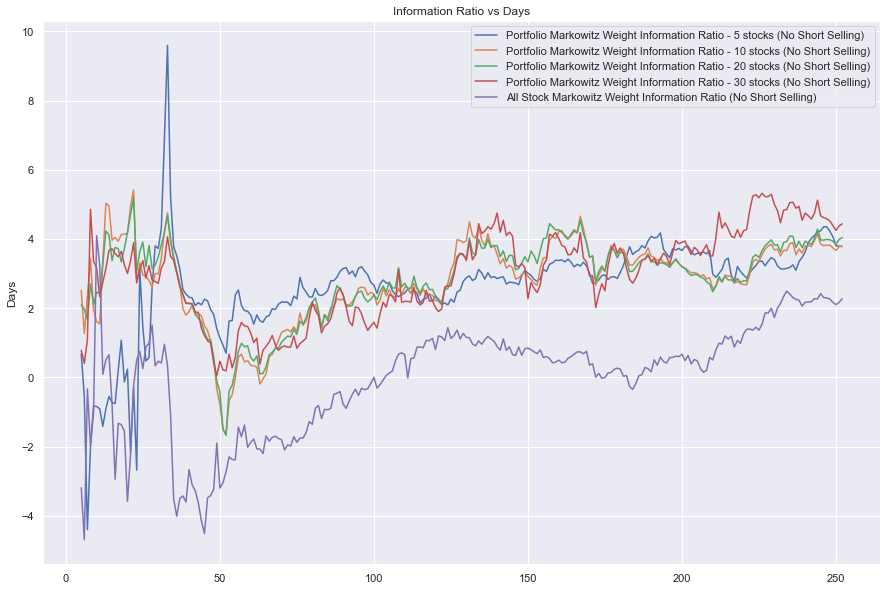

In [65]:
sns.set(rc={'figure.figsize': (15, 10)})
risk_free_rate = 0.001
number_list = [5,10,20,30]
short = False
Markowitz_weight(MST_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, short)

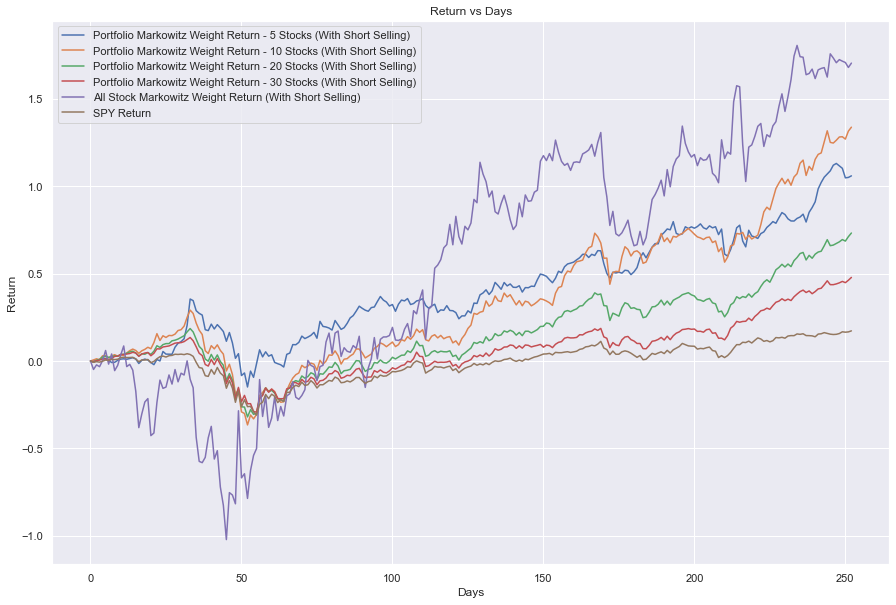

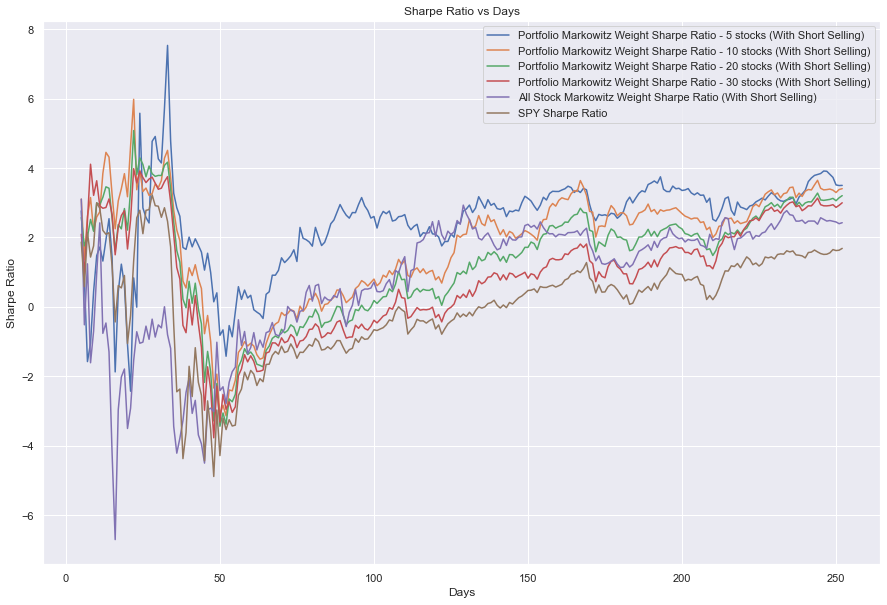

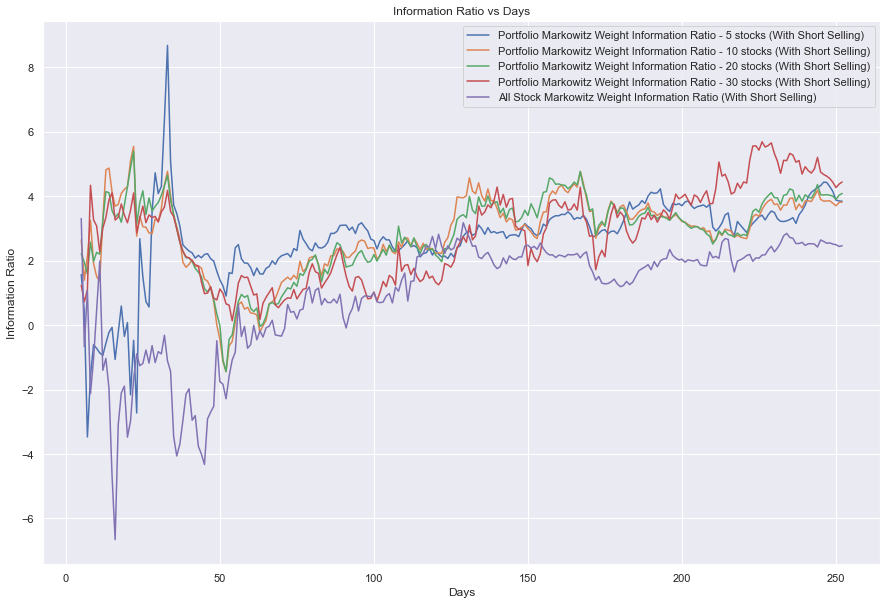

In [280]:
sns.set(rc={'figure.figsize': (15, 10)})
risk_free_rate = 0.001
number_list = [5,10,20,30]
short = True
all_stock_weight = Markowitz_weight(MST_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, short)

In [238]:
MST_degree_is_one_list = []
for (key, value) in MST_degree_dict.items():
    if value[0] == 1:
        MST_degree_is_one_list.append(key)        

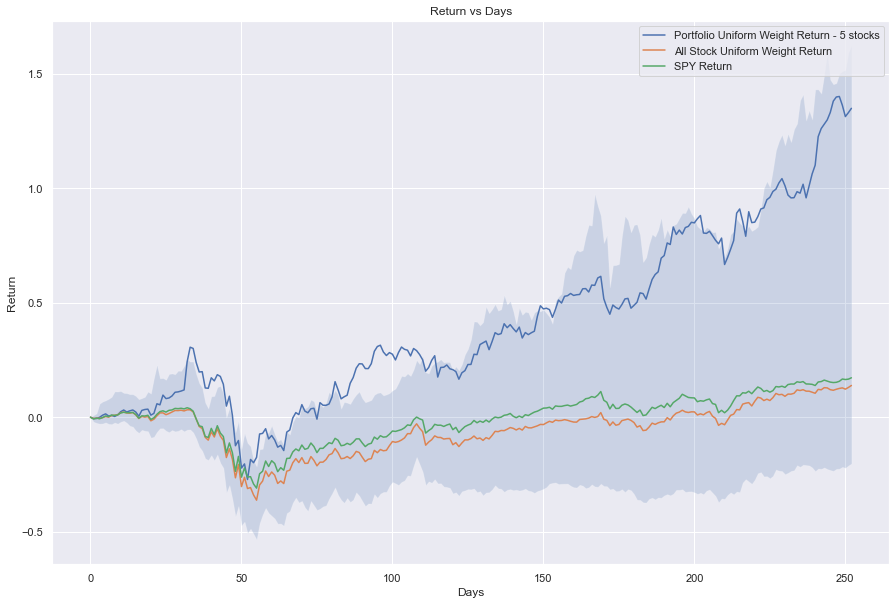

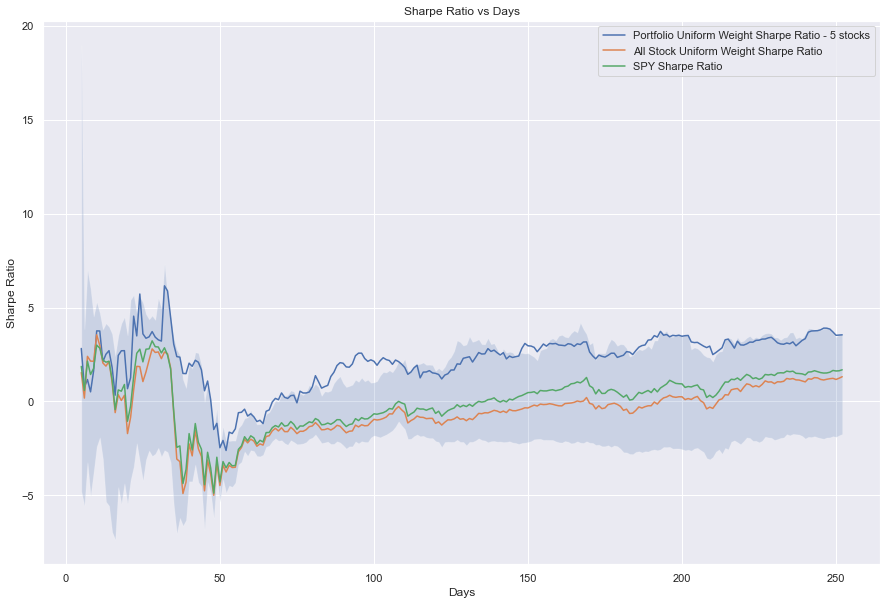

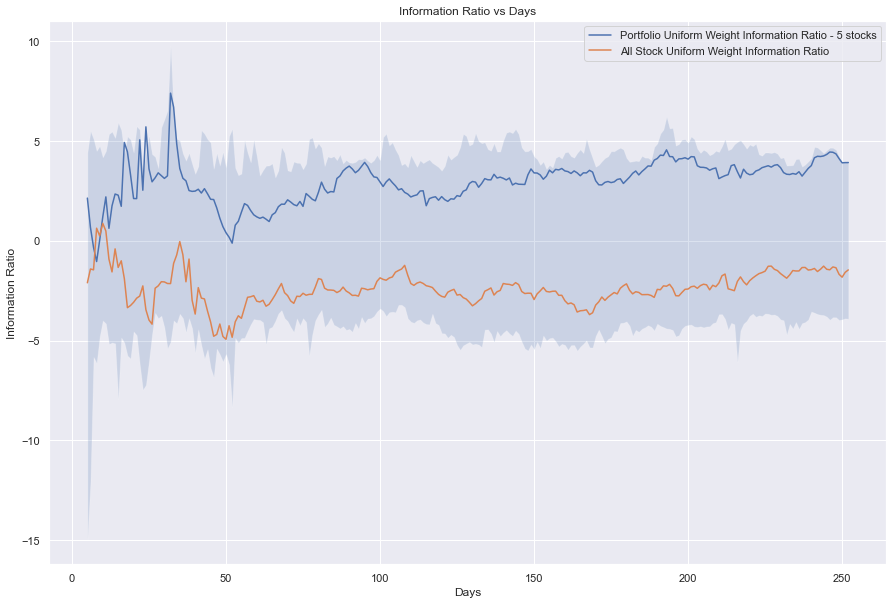

In [256]:
sns.set(rc={'figure.figsize': (15, 10)})
number_list = [5]
risk_free_rate = 0.001
simulations = 100
uniform_weight_band(MST_degree_list,MST_degree_is_one_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, simulations)

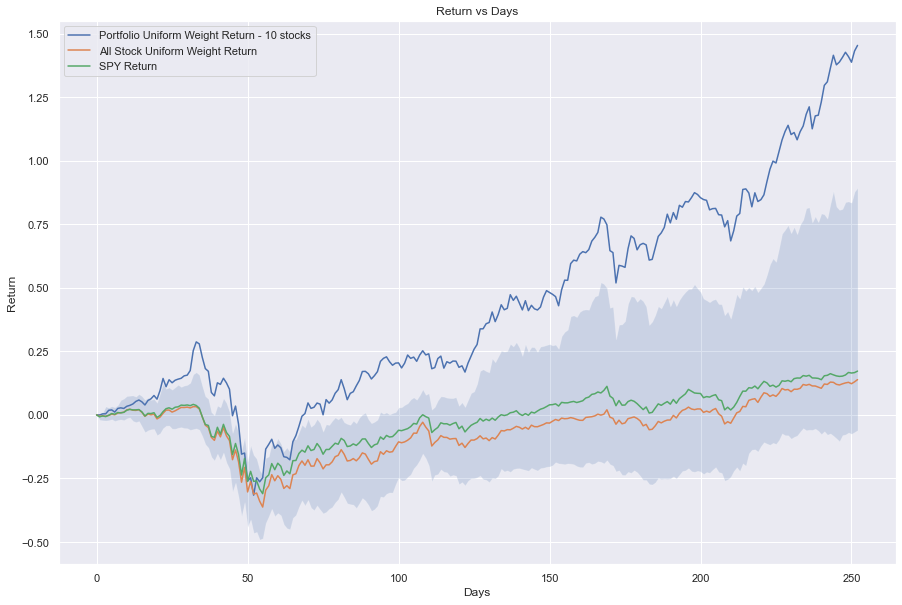

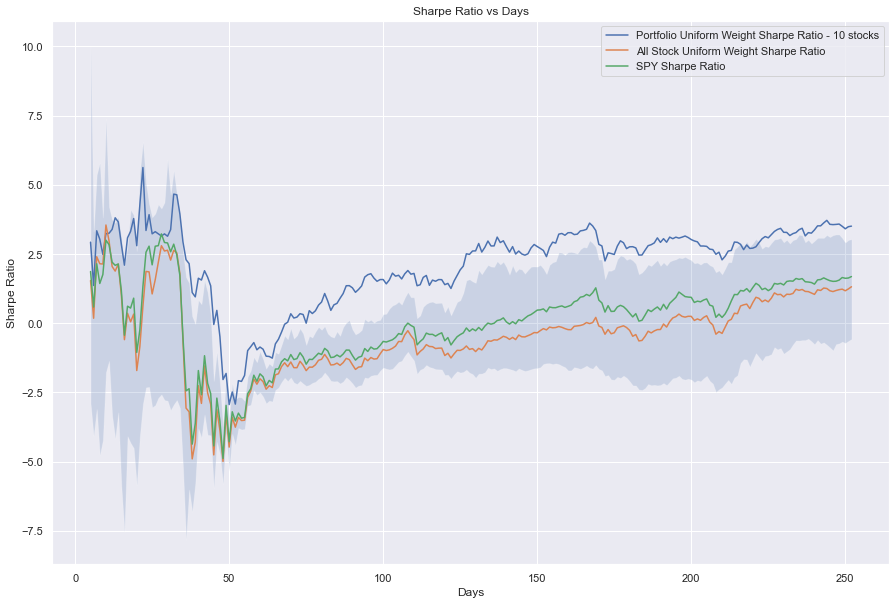

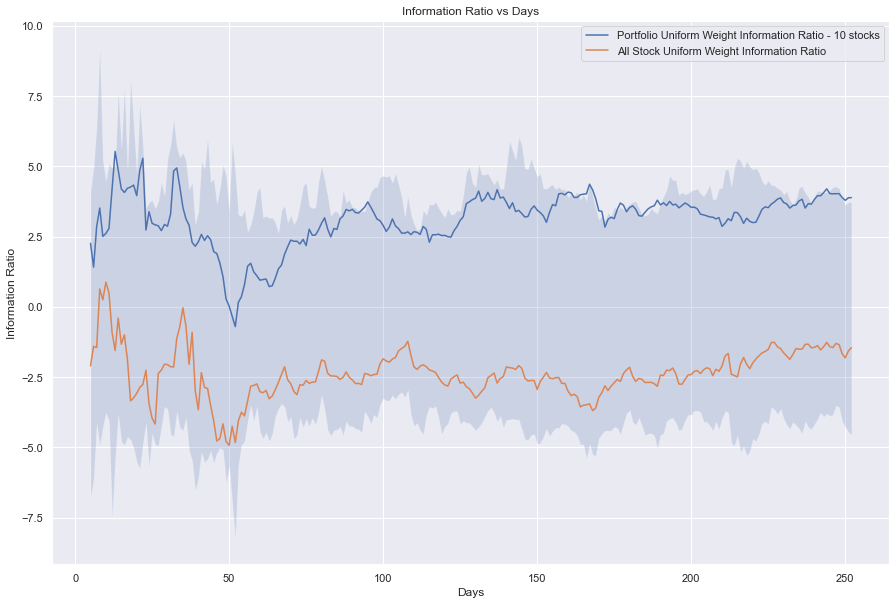

In [257]:
number_list = [10]
risk_free_rate = 0.001
simulations = 100
uniform_weight_band(MST_degree_list,MST_degree_is_one_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, simulations)

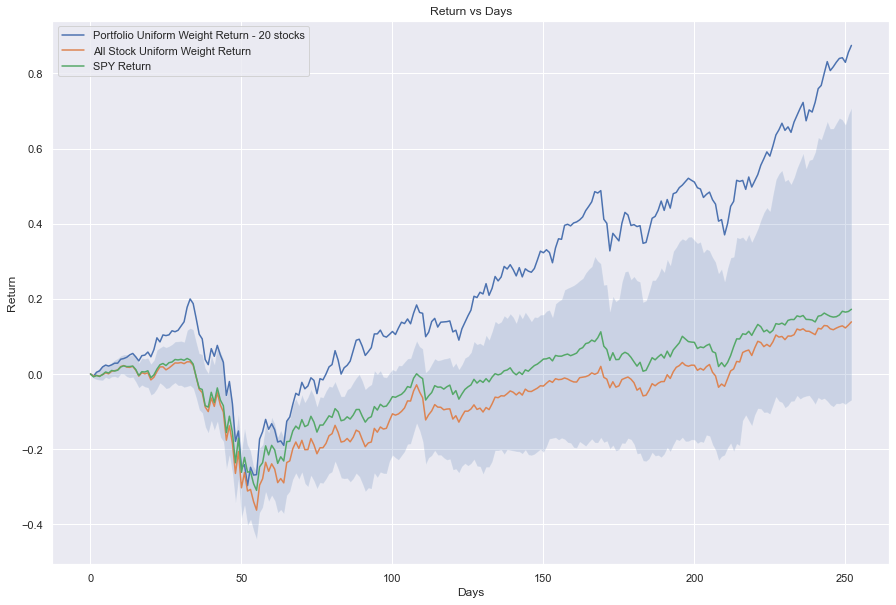

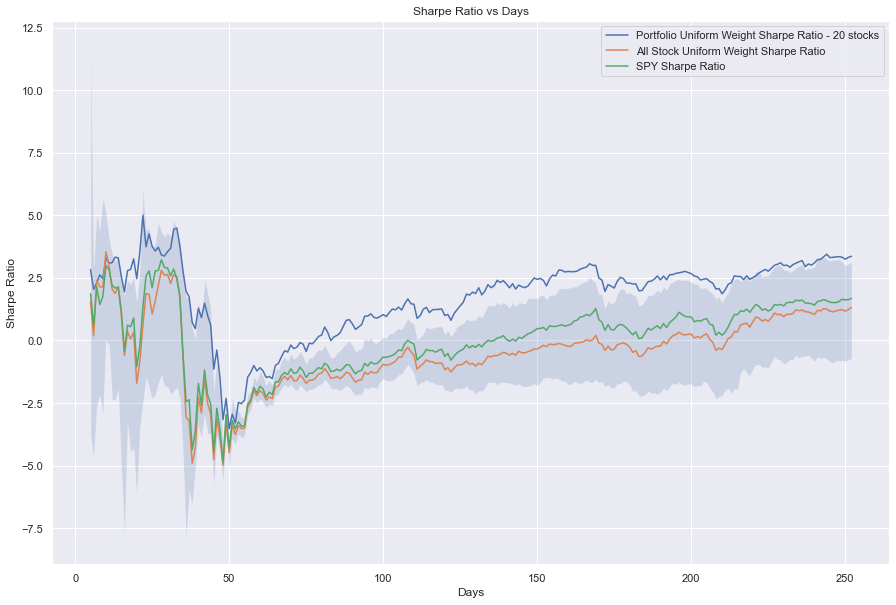

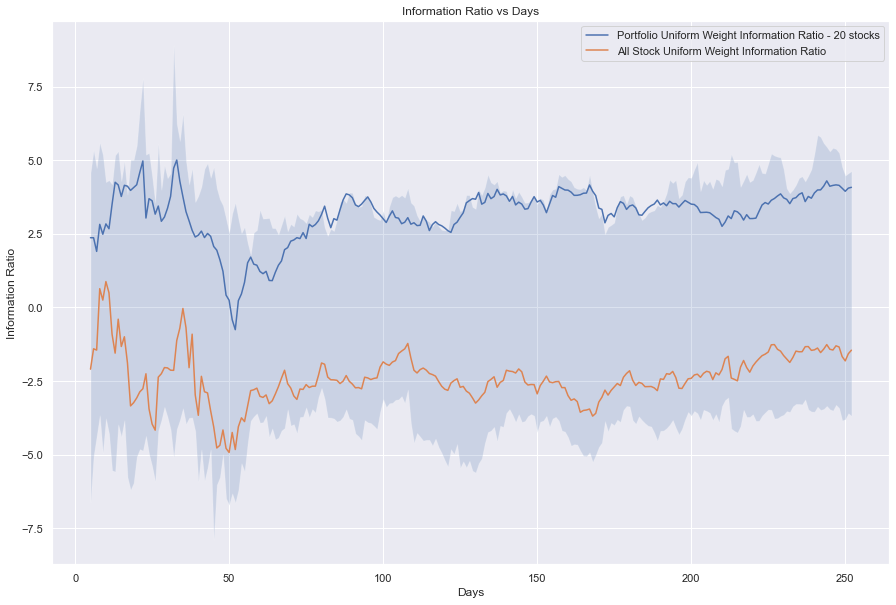

In [258]:
number_list = [20]
risk_free_rate = 0.001
simulations = 100
uniform_weight_band(MST_degree_list,MST_degree_is_one_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, simulations)

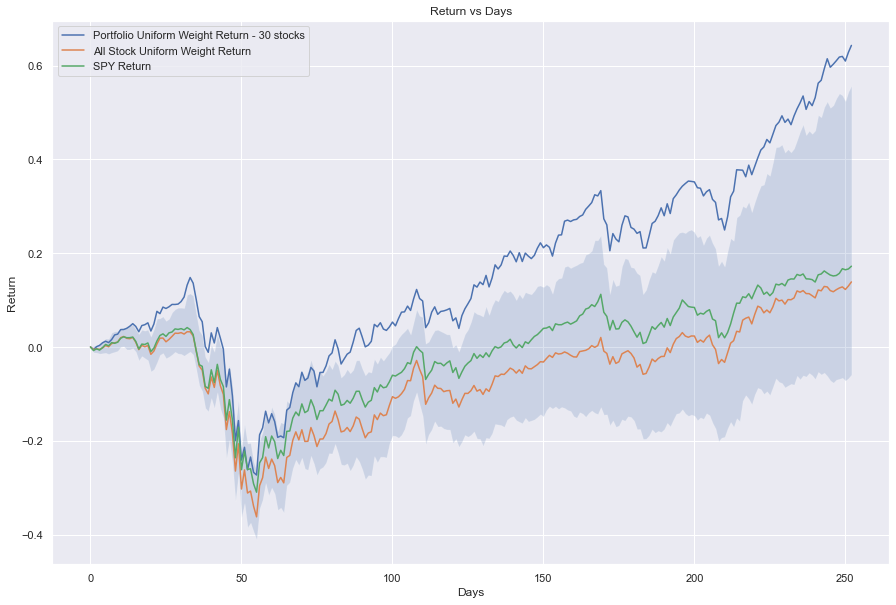

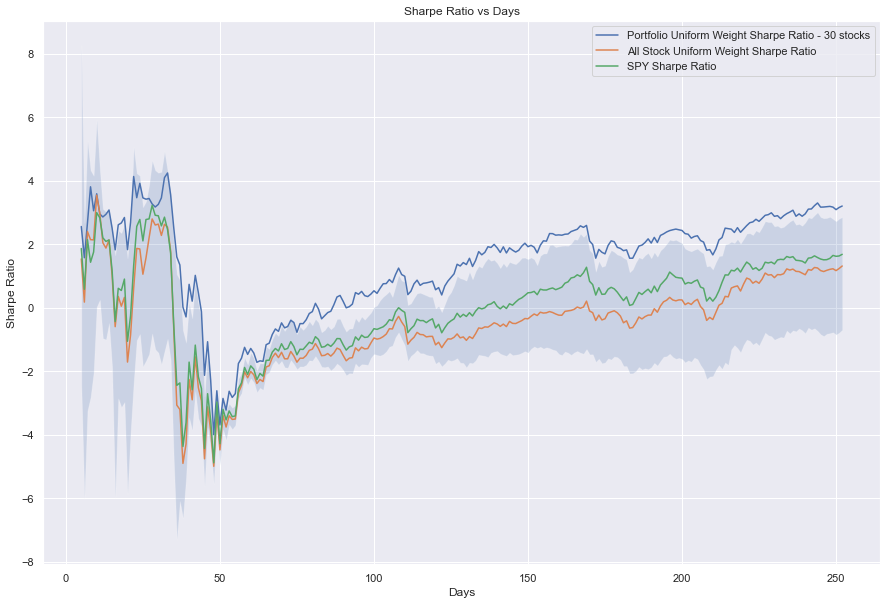

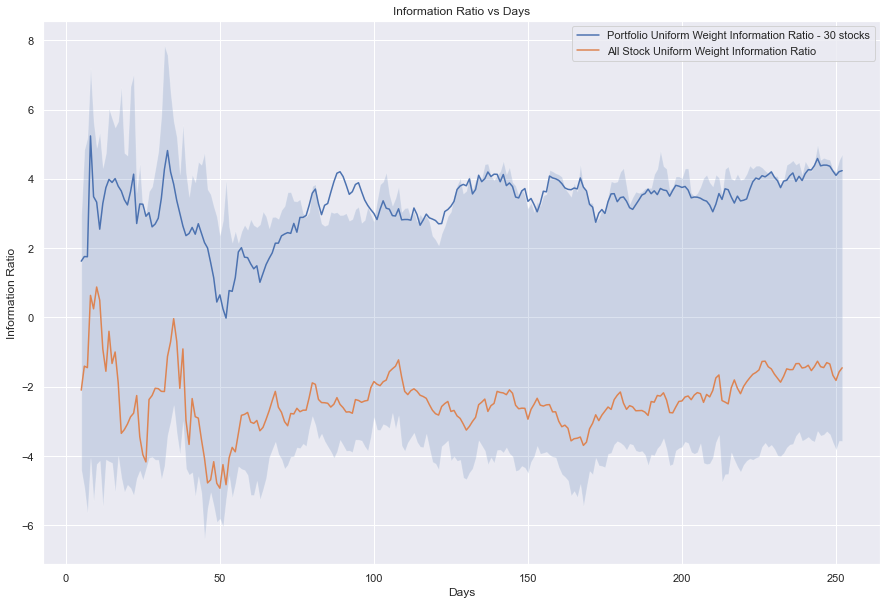

In [259]:
number_list = [30]
risk_free_rate = 0.001
simulations = 100
uniform_weight_band(MST_degree_list,MST_degree_is_one_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, simulations)

## PMFG

In [866]:
PMFG_degree_dict = {}
for k,v in PMFG.degree():
    PMFG_degree_dict[k] = (v,dict(PMFG.degree(weight = 'weight')).get(k))
PMFG_degree_dict = OrderedDict(sorted(PMFG_degree_dict.items(), key=lambda t: t[1][1], reverse = True))
PMFG_degree_dict = OrderedDict(sorted(PMFG_degree_dict.items(), key=lambda t: t[1][0]))
PMFG_degree_list = list(PMFG_degree_dict)

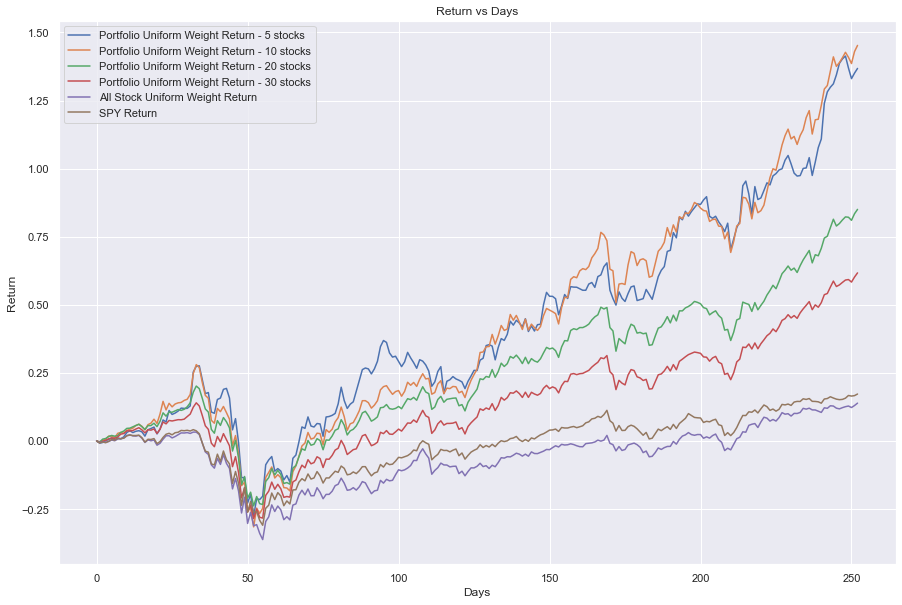

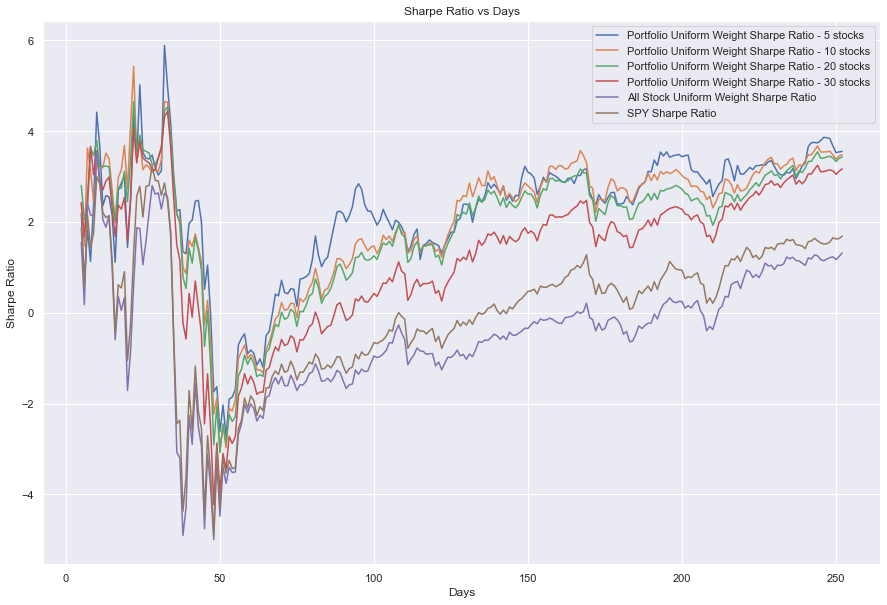

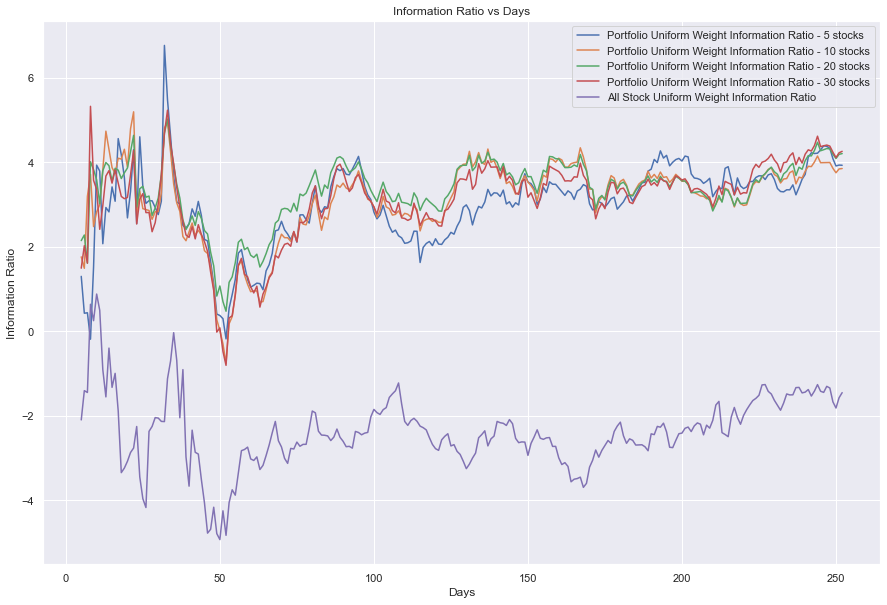

In [323]:
sns.set(rc={'figure.figsize': (15, 10)})
number_list = [5,10,20,30]
risk_free_rate = 0.001
uniform_weight(PMFG_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate)

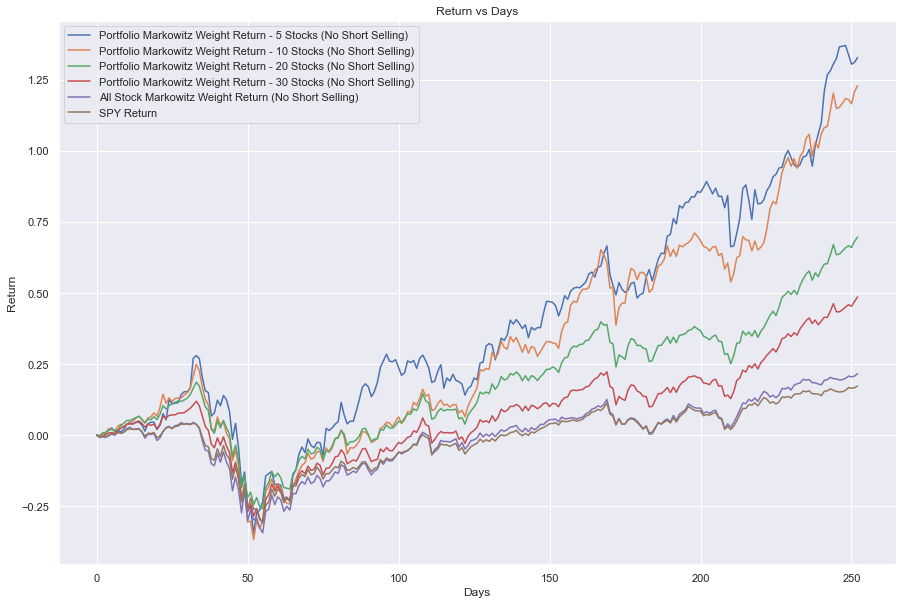

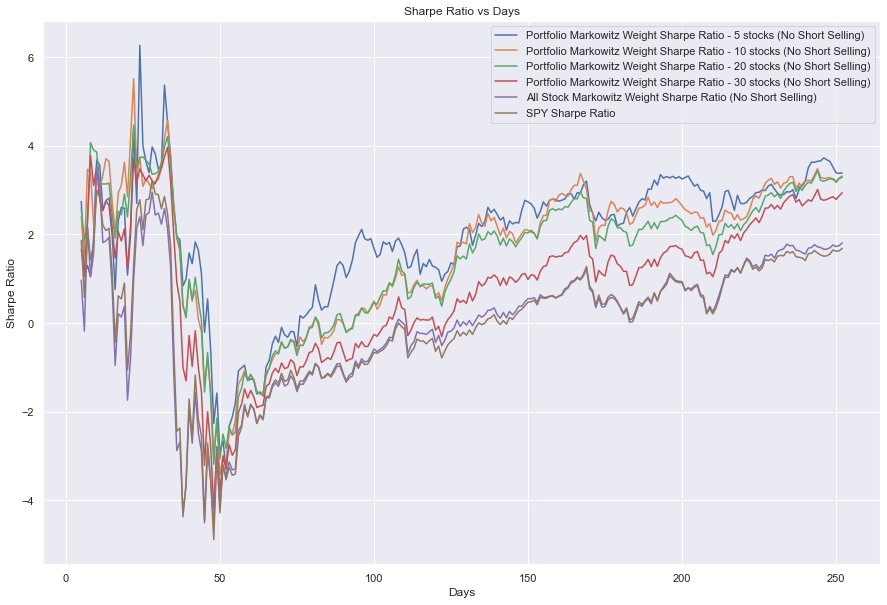

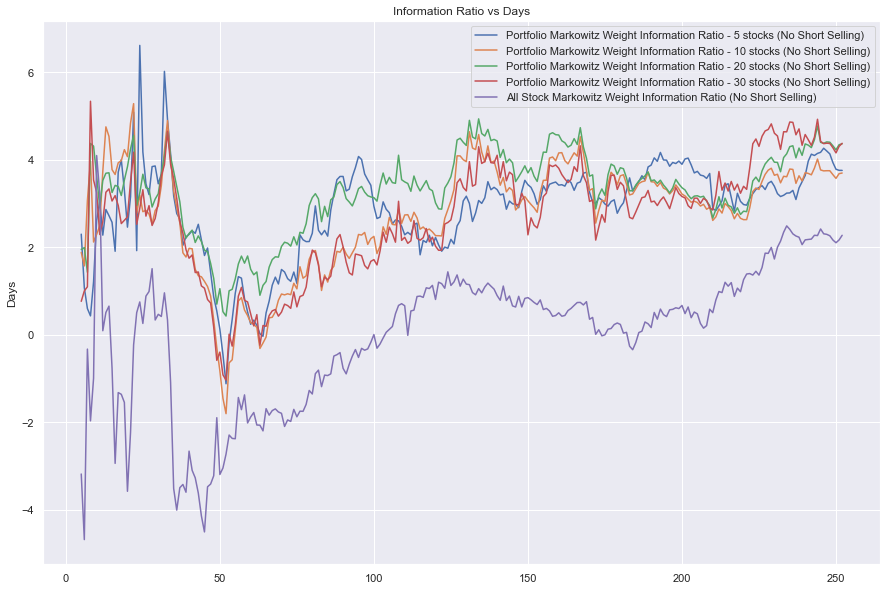

In [324]:
sns.set(rc={'figure.figsize': (15, 10)})
risk_free_rate = 0.001
number_list = [5,10,20,30]
short = False
Markowitz_weight(PMFG_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, short)

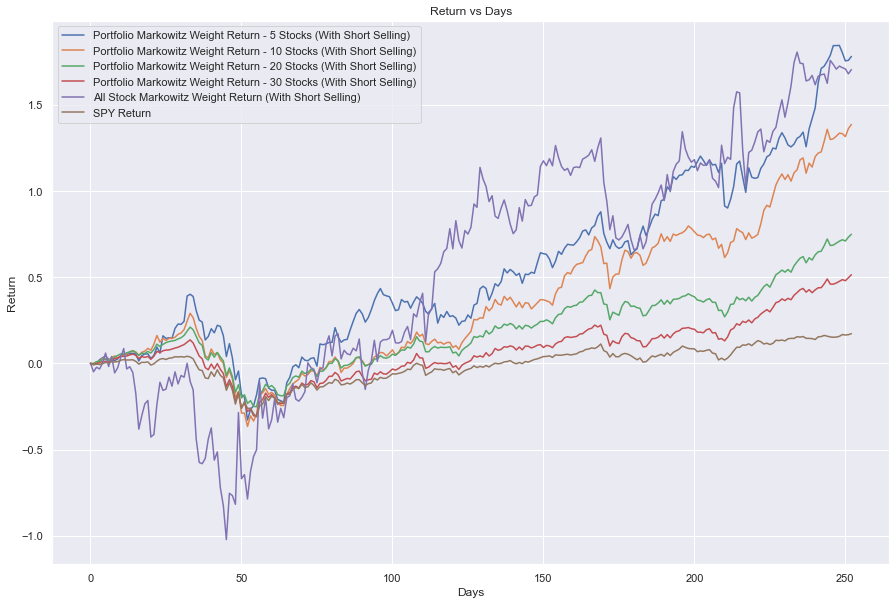

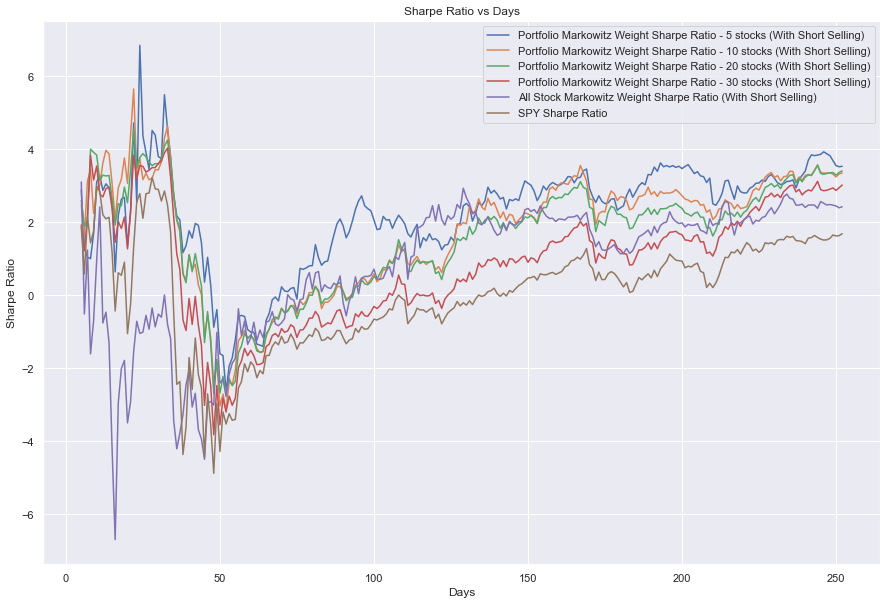

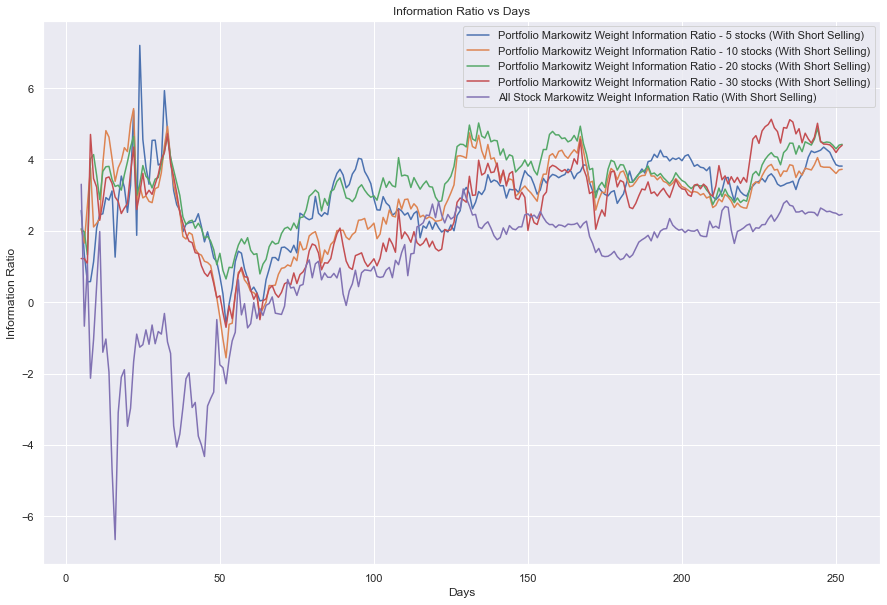

In [325]:
sns.set(rc={'figure.figsize': (15, 10)})
risk_free_rate = 0.001
number_list = [5,10,20,30]
short = True
all_stock_weight = Markowitz_weight(PMFG_degree_list, df_close_price, df_close_price_spy, number_list, risk_free_rate, short)

In [261]:
PMFG_degree_is_three_list = []
for (key, value) in PMFG_degree_dict.items():
    if value[0] == 3:
        PMFG_degree_is_three_list.append(key)   

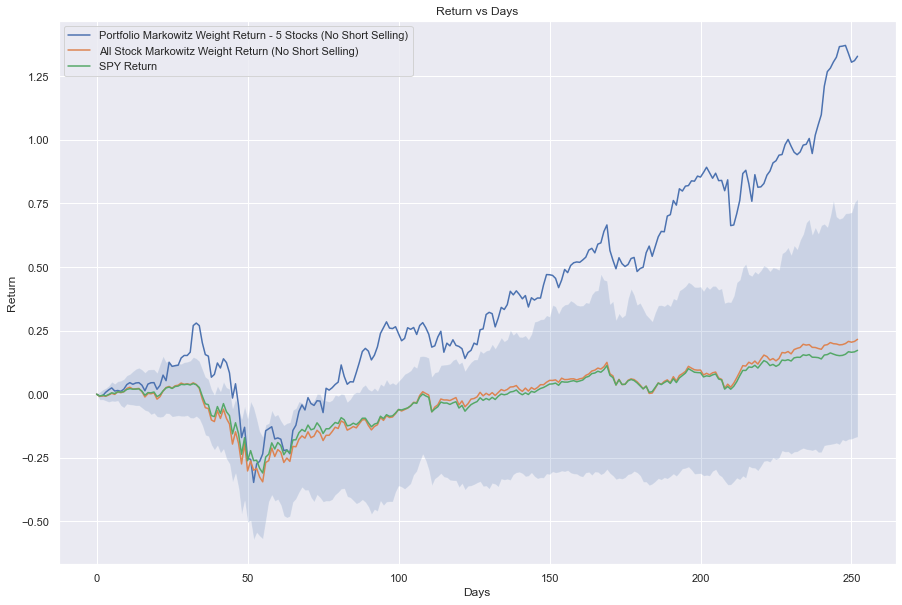

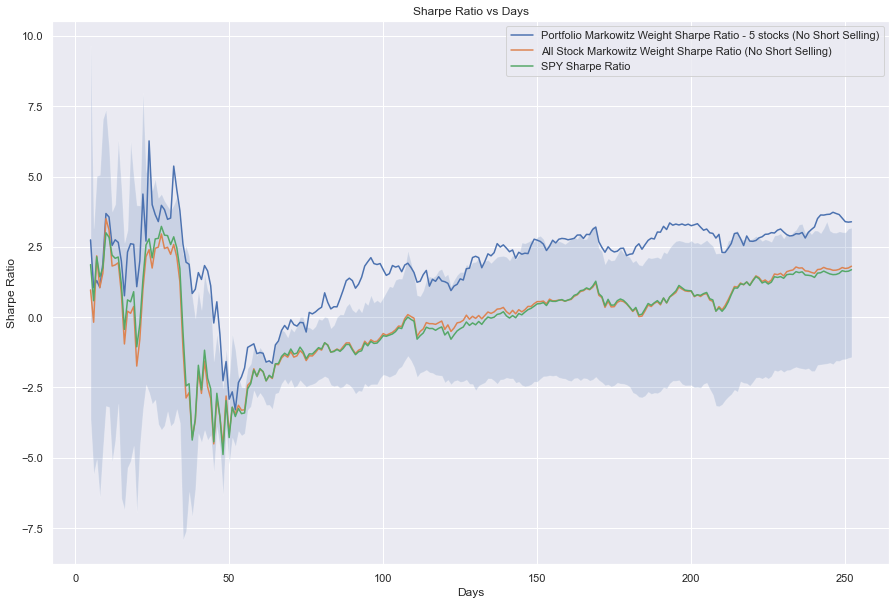

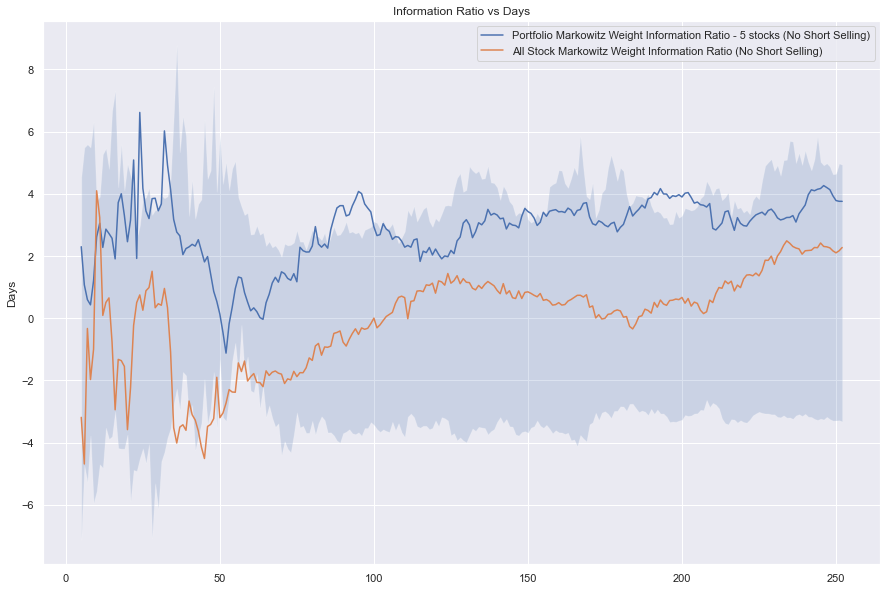

In [347]:
number_list = [5]
risk_free_rate = 0.001
simulations = 100
short = False
Markowitz_weight_band(PMFG_degree_list,PMFG_degree_is_three_list,df_close_price, df_close_price_spy, number_list, risk_free_rate, simulations, short)

In [336]:
c = 1/T*np.dot(R,R.T)
w, v = LA.eig(c)

In [337]:
P = (np.dot(v.T,R).T*1/np.sqrt(w)).T

In [397]:
np.dot(P,P.T)/T

array([[ 1.00000000e+00, -1.47635647e-16, -1.85795436e-18, ...,
        -2.07608159e-15,  6.39531027e-16, -1.17761675e-15],
       [-1.47635647e-16,  1.00000000e+00,  6.47633804e-16, ...,
         8.12981205e-16,  2.97951227e-17,  2.15659936e-16],
       [-1.85795436e-18,  6.47633804e-16,  1.00000000e+00, ...,
        -1.03573522e-16,  2.09629970e-16,  9.50606296e-17],
       ...,
       [-2.07608159e-15,  8.12981205e-16, -1.03573522e-16, ...,
         1.00000000e+00,  3.20024447e-14, -4.48913182e-15],
       [ 6.39531027e-16,  2.97951227e-17,  2.09629970e-16, ...,
         3.20024447e-14,  1.00000000e+00, -1.16451710e-14],
       [-1.17761675e-15,  2.15659936e-16,  9.50606296e-17, ...,
        -4.48913182e-15, -1.16451710e-14,  1.00000000e+00]])

In [409]:
R_removed_PC1 = np.dot(np.sqrt(w[1:])*v.T[1:].T,P[1:])

In [410]:
df_logreturn_removed_PC1 = df_logreturn.copy()
df_logreturn_removed_PC1[:] = R_removed_PC1.T
df_logreturn_normalised = df_logreturn.copy()
df_logreturn_normalised[:] = R.T

In [446]:
ret = np.exp(df_logreturn_removed_PC1*saved_std+saved_mean)
ret.iloc[0] = 1
df_close_price_removed_PC1 = ret.cumprod()

random select, markowitz allocation, confidence interval and box plot

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

In [1025]:
def markowitz_max_sharpe(df_close_price_train, df_close_price, df_close_price_benchmark, sample_number, sample_size, risk_free_rate, short):
    returns = []
    information_ratios = []
    sharpe_ratios = []
    mu = expected_returns.capm_return(df_close_price_train[:test_start],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    for i in range(sample_number):
        df_close_price_this_sample = df_close_price_train.sample(sample_size,axis = 1)
        S = risk_models.CovarianceShrinkage(df_close_price_this_sample[:test_start]).ledoit_wolf()
        if short == False:
            ef = EfficientFrontier(mu.loc[list(df_close_price_this_sample.columns)], S)
        else:
            ef = EfficientFrontier(mu.loc[list(df_close_price_this_sample.columns)], S, weight_bounds=(-1, 1))
        
        ef.max_sharpe(risk_free_rate=risk_free_rate)
        weight = ef.clean_weights()
    
        df_close_price_test = df_close_price.copy()[test_start:]
        df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]
        
        portfolio_return = []
        benchmark_return = []
    
        for i in range(len(df_close_price_test)-1):
            stock_return = []
            for stock in list(df_close_price_this_sample.columns):
                stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*weight.get(stock))
            portfolio_return.append(sum(stock_return))
            benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

        stock_return = []
        for stock in list(df_close_price_this_sample.columns):
            stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weight.get(stock))   
        returns.append(sum(stock_return))
        daily_return = (sum(stock_return)+1)**(1/252)-1
        daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
        daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
        
        information_ratios.append((daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252))
        sharpe_ratios.append((daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252))
    
    return returns,information_ratios,sharpe_ratios
        

In [1026]:
def markowitz_min_var(df_close_price_train, df_close_price, df_close_price_benchmark, sample_number, sample_size, risk_free_rate, short):
    returns = []
    information_ratios = []
    sharpe_ratios = []
    mu = expected_returns.capm_return(df_close_price_train[:test_start],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    for i in range(sample_number):
        df_close_price_this_sample = df_close_price_train.sample(sample_size,axis = 1)
        S = risk_models.CovarianceShrinkage(df_close_price_this_sample[:test_start]).ledoit_wolf()
        if short == False:
            ef = EfficientFrontier(mu.loc[list(df_close_price_this_sample.columns)], S)
        else:
            ef = EfficientFrontier(mu.loc[list(df_close_price_this_sample.columns)], S, weight_bounds=(-1, 1))
        ef.min_volatility()
        weight = ef.clean_weights()
    
        df_close_price_test = df_close_price.copy()[test_start:]
        df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]
        
        portfolio_return = []
        benchmark_return = []
    
        for i in range(len(df_close_price_test)-1):
            stock_return = []
            for stock in list(df_close_price_this_sample.columns):
                stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*weight.get(stock))
            portfolio_return.append(sum(stock_return))
            benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

        stock_return = []
        for stock in list(df_close_price_this_sample.columns):
            stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weight.get(stock))   
        returns.append(sum(stock_return))
        daily_return = (sum(stock_return)+1)**(1/252)-1
        daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
        daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
        
        information_ratios.append((daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252))
        sharpe_ratios.append((daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252))
    
    return returns,information_ratios,sharpe_ratios

In [1046]:
def uniform_weights(df_close_price_train, df_close_price, df_close_price_benchmark, sample_number, sample_size, risk_free_rate, short):
    returns = []
    information_ratios = []
    sharpe_ratios = []
    for i in range(sample_number):
        df_close_price_this_sample = df_close_price_train.sample(sample_size,axis = 1)
        
        df_close_price_test = df_close_price.copy()[test_start:]
        df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]
        
        portfolio_return = []
        benchmark_return = []
    
        for i in range(len(df_close_price_test)-1):
            stock_return = []
            for stock in list(df_close_price_this_sample.columns):
                stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*1/sample_size)
            portfolio_return.append(sum(stock_return))
            benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

        stock_return = []
        for stock in list(df_close_price_this_sample.columns):
            stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*1/sample_size)   
        returns.append(sum(stock_return))
        
        daily_return = (sum(stock_return)+1)**(1/252)-1
        daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
        daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
        
        information_ratios.append((daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252))
        sharpe_ratios.append((daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252))
        
    return returns,information_ratios,sharpe_ratios

In [1028]:
def network_performance_max_sharpe(degree_list,m,df_close_price_train,df_close_price,df_close_price_benchmark, risk_free_rate, short):
    mu = expected_returns.capm_return(df_close_price_train[degree_list[:m]][:test_start],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    S = risk_models.CovarianceShrinkage(df_close_price_train[degree_list[:m]][:test_start]).ledoit_wolf()
    if short == False:
        ef = EfficientFrontier(mu, S)
    else:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    ef.max_sharpe(risk_free_rate=risk_free_rate)
    weight = ef.clean_weights()
    
    df_close_price_test = df_close_price.copy()[test_start:]
    df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]

    portfolio_return = []
    benchmark_return = []

    for i in range(len(df_close_price_test)-1):
        stock_return = []
        for stock in degree_list[:m]:
            stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*weight.get(stock))
        portfolio_return.append(sum(stock_return))
        benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

    stock_return = []
    for stock in degree_list[:m]:
        stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weight.get(stock))  
    
    daily_return = (sum(stock_return)+1)**(1/252)-1
    daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
    daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
    information_ratio = (daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252)
    sharpe_ratio = (daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252)

    return sum(stock_return),information_ratio,sharpe_ratio

In [1029]:
def network_performance_min_var(degree_list,m,df_close_price_train,df_close_price,df_close_price_benchmark, risk_free_rate, short):
    mu = expected_returns.capm_return(df_close_price_train[degree_list[:m]][:test_start],df_close_price_benchmark[:test_start],risk_free_rate=risk_free_rate)
    S = risk_models.CovarianceShrinkage(df_close_price_train[degree_list[:m]][:test_start]).ledoit_wolf()
    if short == False:
        ef = EfficientFrontier(mu, S)
    else:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    ef.min_volatility()
    weight = ef.clean_weights()
    
    df_close_price_test = df_close_price.copy()[test_start:]
    df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]

    portfolio_return = []
    benchmark_return = []

    for i in range(len(df_close_price_test)-1):
        stock_return = []
        for stock in degree_list[:m]:
            stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*weight.get(stock))
        portfolio_return.append(sum(stock_return))
        benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

    stock_return = []
    for stock in degree_list[:m]:
        stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*weight.get(stock))  
    
    
    daily_return = (sum(stock_return)+1)**(1/252)-1
    daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
    daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
    information_ratio = (daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252)
    sharpe_ratio = (daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252)

    return sum(stock_return),information_ratio,sharpe_ratio

In [1045]:
def network_performance_uniform_weights(degree_list,m,df_close_price_train,df_close_price,df_close_price_benchmark, risk_free_rate, short):
    
    df_close_price_test = df_close_price.copy()[test_start:]
    df_close_price_benchmark_test = df_close_price_benchmark.copy()[test_start:]

    portfolio_return = []
    benchmark_return = []

    for i in range(len(df_close_price_test)-1):
        stock_return = []
        for stock in degree_list[:m]:
            stock_return.append((df_close_price_test[stock][i+1]-df_close_price_test[stock][i])/df_close_price_test[stock][i]*1/m)
        portfolio_return.append(sum(stock_return))
        benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])

    stock_return = []
    for stock in degree_list[:m]:
        stock_return.append((df_close_price_test[stock][-1]-df_close_price_test[stock][0])/df_close_price_test[stock][0]*1/m)  
    
    
    daily_return = (sum(stock_return)+1)**(1/252)-1
    daily_risk_free_rate = (risk_free_rate+1)**(1/252)-1
    daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
    information_ratio = (daily_return-daily_benchmark_return)/np.std([x - y for x, y in zip(portfolio_return, benchmark_return)])*np.sqrt(252)
    sharpe_ratio = (daily_return-daily_risk_free_rate)/np.std(portfolio_return)*np.sqrt(252)
    
    return sum(stock_return),information_ratio,sharpe_ratio

# m = 10

In [1051]:
all_returns = []
all_information_ratios = []
all_sharpe_ratios = []

In [1052]:
risk_free_rate = 0.02
short = False
sample_number = 1000
sample_size = 10
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1054]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1055]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1056]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1057]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1058]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1059]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1060]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

In [1061]:
short = True
returns,information_ratios,sharpe_ratios = uniform_weights(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns.append(returns)
all_information_ratios.append(information_ratios)
all_sharpe_ratios.append(sharpe_ratios)

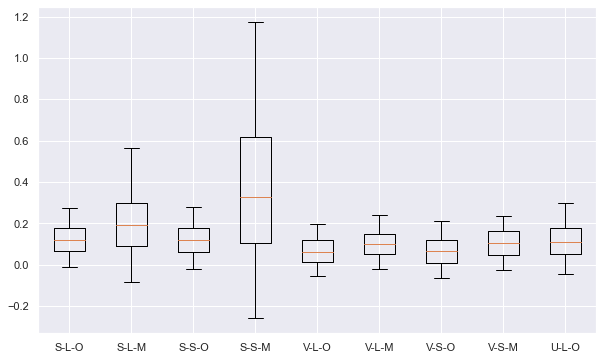

In [1114]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

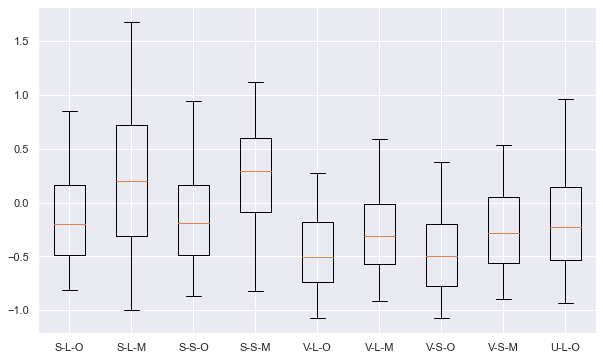

In [1115]:
plt.boxplot(all_information_ratios,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

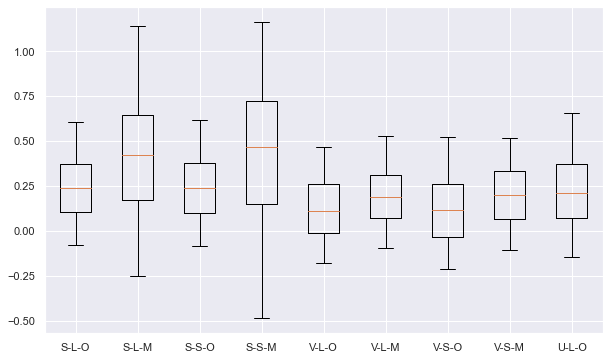

In [1116]:
plt.boxplot(all_sharpe_ratios,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

In [1067]:
MST_network_returns = []
MST_information_ratios = []
MST_sharpe_ratios = []
PMFG_network_returns = []
PMFG_information_ratios = []
PMFG_sharpe_ratios = []

In [1068]:
risk_free_rate = 0.02
m = 10
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1069]:
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1070]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1071]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1072]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1073]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1074]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1075]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

In [1078]:
r,ir,sr = network_performance_uniform_weights(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns.append(r)
MST_information_ratios.append(ir)
MST_sharpe_ratios.append(sr)

In [1120]:
r,ir,sr = network_performance_uniform_weights(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns.append(r)
PMFG_information_ratios.append(ir)
PMFG_sharpe_ratios.append(sr)

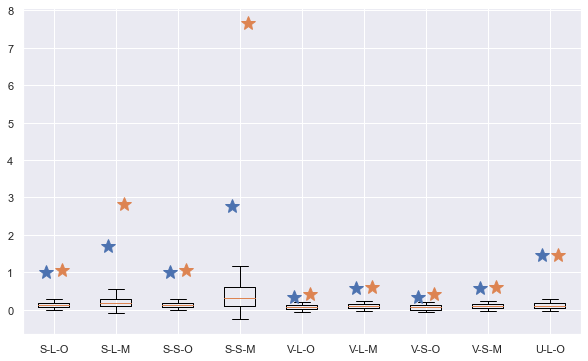

In [1132]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_network_returns,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_network_returns,'*', markersize=15)
plt.show()

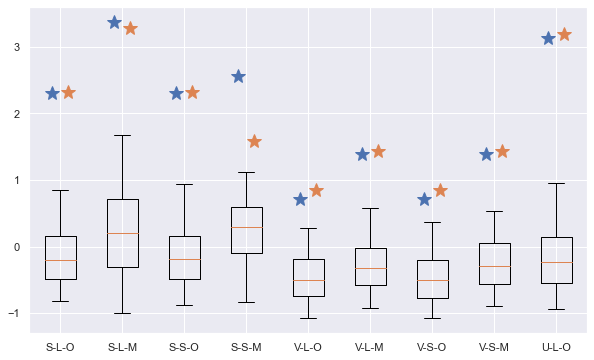

In [1133]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_information_ratios,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_information_ratios,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_information_ratios,'*', markersize=15)
plt.show()

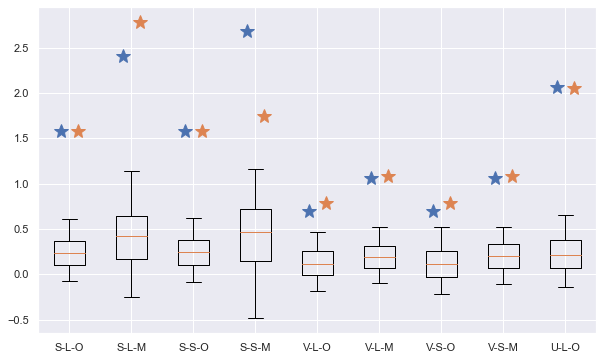

In [1134]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_sharpe_ratios,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_sharpe_ratios,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_sharpe_ratios,'*', markersize=15)
plt.show()

# m = 20

















In [1165]:
all_returns_20 = []
all_information_ratios_20 = []
all_sharpe_ratios_20 = []

In [1166]:
risk_free_rate = 0.02
short = False
sample_number = 1000
sample_size = 20
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1167]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1168]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1169]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1170]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1171]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1172]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1173]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

In [1174]:
short = True
returns,information_ratios,sharpe_ratios = uniform_weights(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_20.append(returns)
all_information_ratios_20.append(information_ratios)
all_sharpe_ratios_20.append(sharpe_ratios)

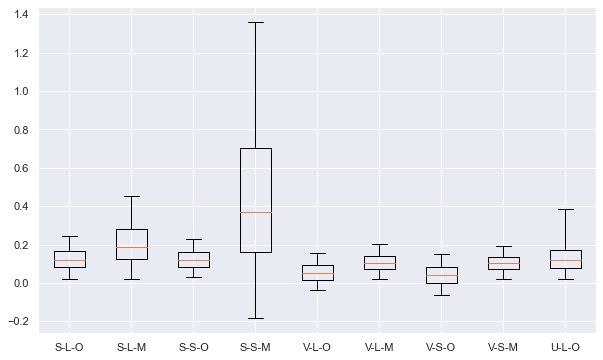

In [1175]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

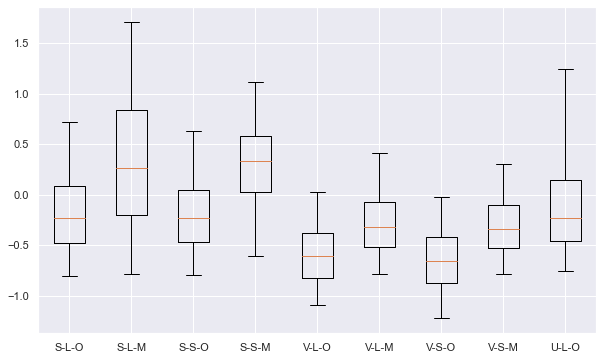

In [1176]:
plt.boxplot(all_information_ratios_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

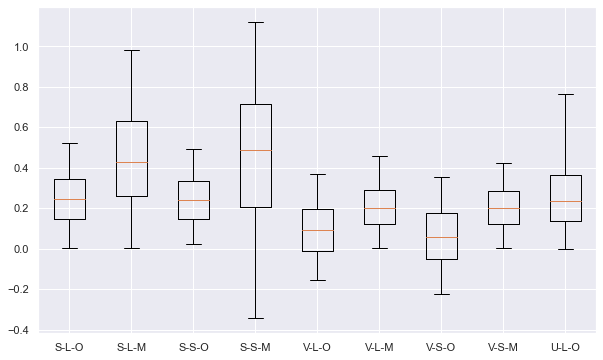

In [1177]:
plt.boxplot(all_sharpe_ratios_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

In [1178]:
MST_network_returns_20 = []
MST_information_ratios_20 = []
MST_sharpe_ratios_20 = []
PMFG_network_returns_20 = []
PMFG_information_ratios_20 = []
PMFG_sharpe_ratios_20 = []

In [1179]:
risk_free_rate = 0.02
m = 20
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1180]:
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1181]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1182]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1183]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1184]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1185]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1186]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

In [1187]:
r,ir,sr = network_performance_uniform_weights(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_20.append(r)
MST_information_ratios_20.append(ir)
MST_sharpe_ratios_20.append(sr)

In [1188]:
r,ir,sr = network_performance_uniform_weights(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_20.append(r)
PMFG_information_ratios_20.append(ir)
PMFG_sharpe_ratios_20.append(sr)

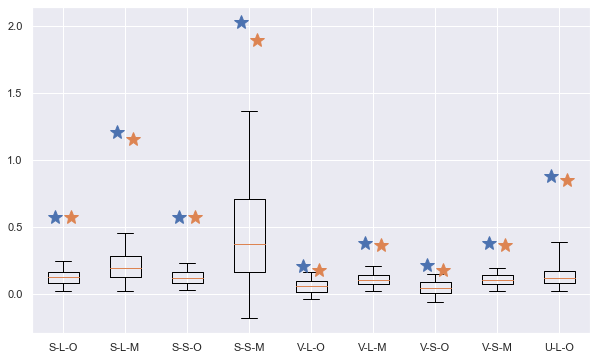

In [1189]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_network_returns_20,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_network_returns_20,'*', markersize=15)
plt.show()

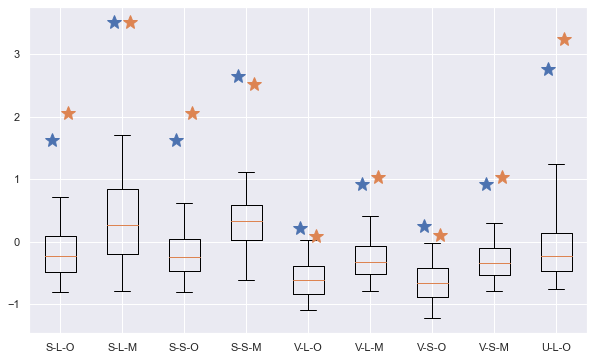

In [1190]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_information_ratios_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_information_ratios_20,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_information_ratios_20,'*', markersize=15)
plt.show()

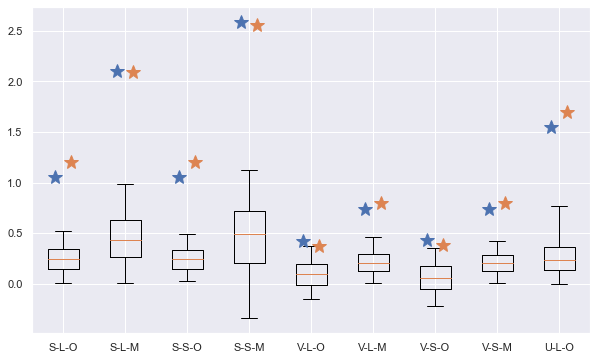

In [1191]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_sharpe_ratios_20,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_sharpe_ratios_20,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_sharpe_ratios_20,'*', markersize=15)
plt.show()

# m = 50

















In [1192]:
all_returns_50 = []
all_information_ratios_50 = []
all_sharpe_ratios_50 = []

In [1193]:
risk_free_rate = 0.02
short = False
sample_number = 1000
sample_size = 50
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1194]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1195]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1196]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_max_sharpe(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1197]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1198]:
short = False
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1199]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1200]:
short = True
returns,information_ratios,sharpe_ratios = markowitz_min_var(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

In [1201]:
short = True
returns,information_ratios,sharpe_ratios = uniform_weights(df_close_price_removed_PC1,df_close_price, df_close_price_spy, sample_number, sample_size, risk_free_rate, short)
all_returns_50.append(returns)
all_information_ratios_50.append(information_ratios)
all_sharpe_ratios_50.append(sharpe_ratios)

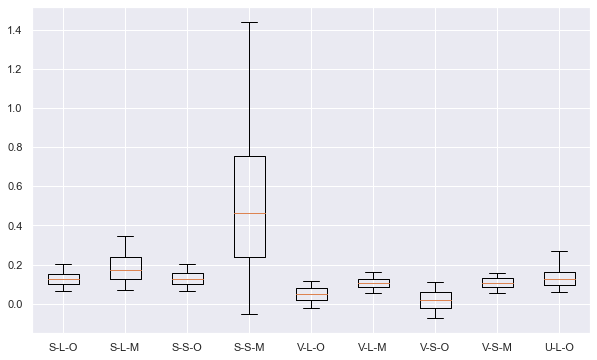

In [1202]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

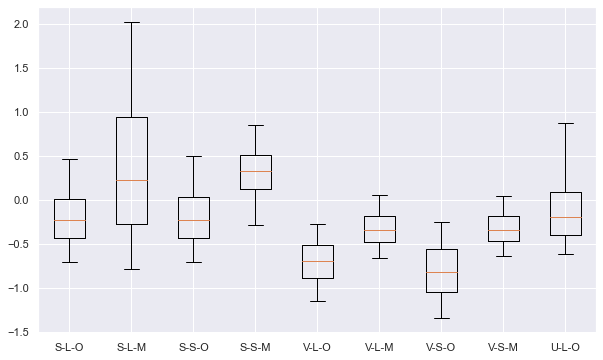

In [1221]:
plt.boxplot(all_information_ratios_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

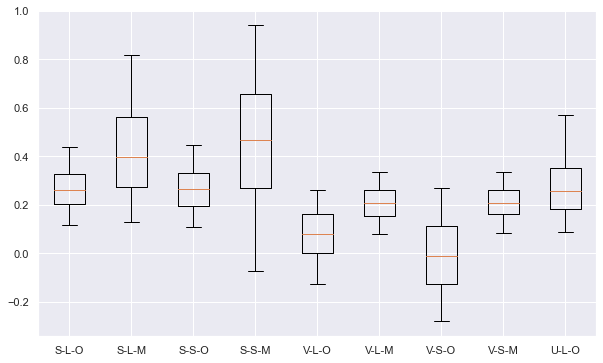

In [1223]:
plt.boxplot(all_sharpe_ratios_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.show()

In [1205]:
MST_network_returns_50 = []
MST_information_ratios_50 = []
MST_sharpe_ratios_50 = []
PMFG_network_returns_50 = []
PMFG_information_ratios_50 = []
PMFG_sharpe_ratios_50 = []

In [1206]:
risk_free_rate = 0.02
m = 50
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1207]:
short = False
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1208]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1209]:
short = True
r,ir,sr = network_performance_max_sharpe(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_max_sharpe(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1210]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1211]:
short = False
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1212]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1213]:
short = True
r,ir,sr = network_performance_min_var(MST_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)
r,ir,sr = network_performance_min_var(PMFG_degree_list,m,df_close_price_removed_PC1,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

In [1214]:
r,ir,sr = network_performance_uniform_weights(MST_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
MST_network_returns_50.append(r)
MST_information_ratios_50.append(ir)
MST_sharpe_ratios_50.append(sr)

In [1215]:
r,ir,sr = network_performance_uniform_weights(PMFG_degree_list,m,df_close_price,df_close_price,df_close_price_spy, risk_free_rate, short)
PMFG_network_returns_50.append(r)
PMFG_information_ratios_50.append(ir)
PMFG_sharpe_ratios_50.append(sr)

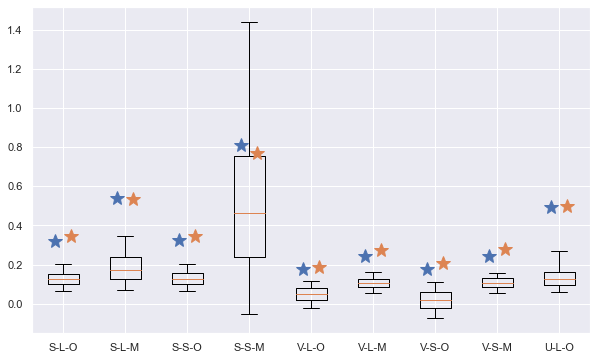

In [1224]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_returns_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_network_returns_50,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_network_returns_50,'*', markersize=15)
plt.show()

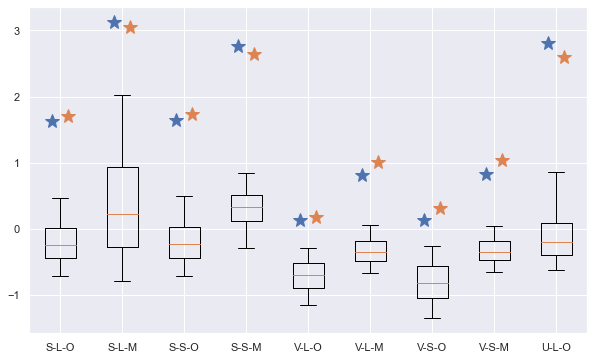

In [1225]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_information_ratios_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_information_ratios_50,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_information_ratios_50,'*', markersize=15)
plt.show()

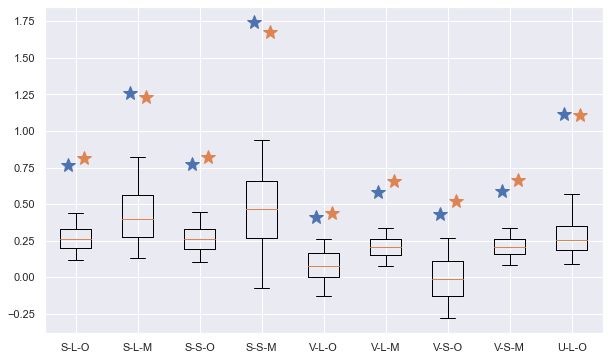

In [1226]:
sns.set(rc={'figure.figsize':(10,6)})
plt.boxplot(all_sharpe_ratios_50,whis = [5, 95], showfliers = False, labels = ['S-L-O','S-L-M','S-S-O','S-S-M','V-L-O','V-L-M','V-S-O','V-S-M','U-L-O'])
plt.plot(np.arange(9)+0.87, MST_sharpe_ratios_50,'*', markersize=15)
plt.plot(np.arange(9)+1.13, PMFG_sharpe_ratios_50,'*', markersize=15)
plt.show()

In [1233]:
df_close_price_benchmark_test = df_close_price_spy.copy()[test_start:]
benchmark_return = []
for i in range(len(df_close_price_benchmark_test)-1):
    benchmark_return.append((df_close_price_benchmark_test.iloc[i+1][0]-df_close_price_benchmark_test.iloc[i][0])/df_close_price_benchmark_test.iloc[i][0])
print((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])
daily_benchmark_return = (((df_close_price_benchmark_test.iloc[-1][0]-df_close_price_benchmark_test.iloc[0][0])/df_close_price_benchmark_test.iloc[0][0])+1)**(1/252)-1
daily_risk_free_rate = (0.02+1)**(1/252)-1
(daily_benchmark_return-daily_risk_free_rate)/np.std(benchmark_return)*np.sqrt(252)

0.15292906541696086


0.35599336419291944

In [1256]:
a = 3
print(round(MST_network_returns[a]*100,1))
print(round(MST_sharpe_ratios[a],3))
print(round(MST_information_ratios[a],3))

276.7
2.69
2.557


In [1257]:
a = 3
print(round(PMFG_network_returns[a]*100,1))
print(round(PMFG_sharpe_ratios[a],3))
print(round(PMFG_information_ratios[a],3))

766.0
1.752
1.583
